In [1]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime

spark = SparkSession.builder. \
    config("spark.driver.memory", "2g"). \
    config("spark.executor.memory", "8g"). \
    config("spark.executor.cores", "4"). \
    config("spark.executor.instances", "1").appName("test").getOrCreate()



# group_on_both_results_dec_sev

22/07/23 12:52:35 WARN Utils: Your hostname, prapuls-MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.0.16 instead (on interface en0)
22/07/23 12:52:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/23 12:52:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Geographical analysis
import geopandas as gpf #libspatialindex nees to be installed first
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import descartes

# accessibility analysis
import time
from pandana.loaders import osm
from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

#Hide warnings
import warnings
warnings.filterwarnings('ignore')
import math
# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
from statsmodels.tsa.statespace.sarimax import SARIMAX


print('Libraries imported.')

Libraries imported.


In [3]:
# reading seasonalities data
seas_df = spark.read.csv('/Users/prapul/Documents/Exported Tables/seasonalities.csv', header = True, inferSchema = True)

In [4]:
# transforming the data for easy operations later on
seas_df = seas_df.withColumn("date", F.date_format('date', "yyyy-MM-dd").cast(DateType()))


In [5]:
#converting to pandas for visualization
seas_df_pd = seas_df.toPandas()
seas_df_pd = seas_df_pd.set_index('date')

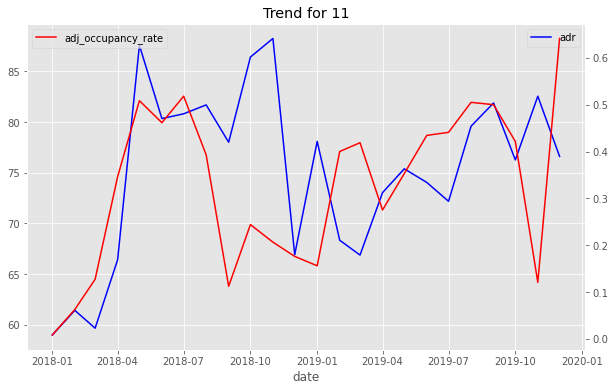

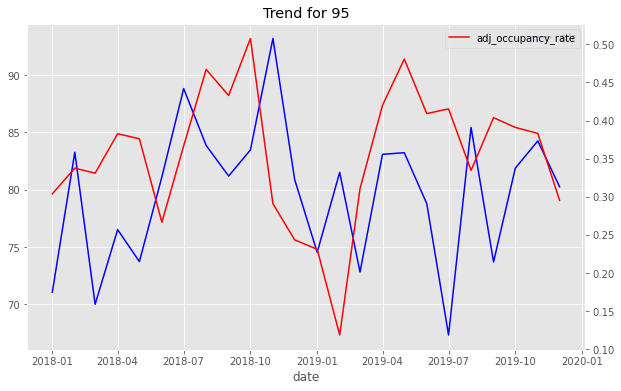

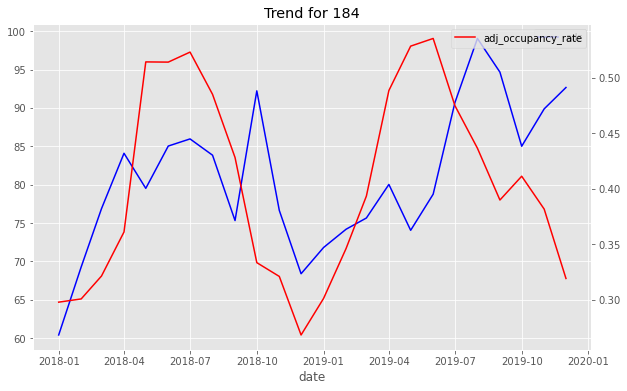

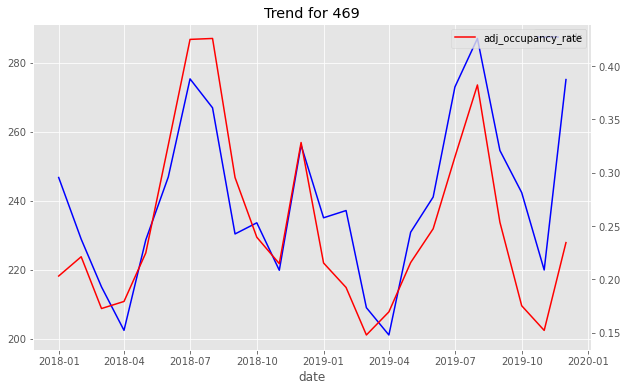

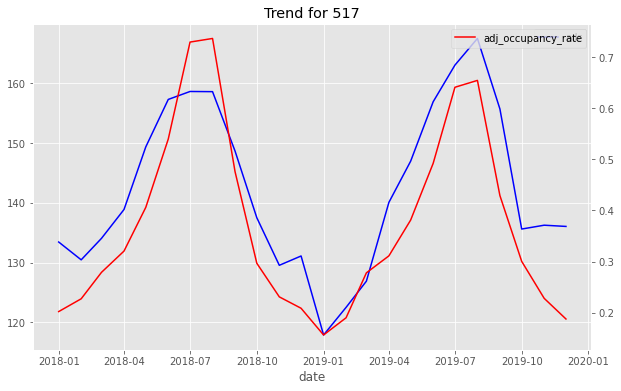

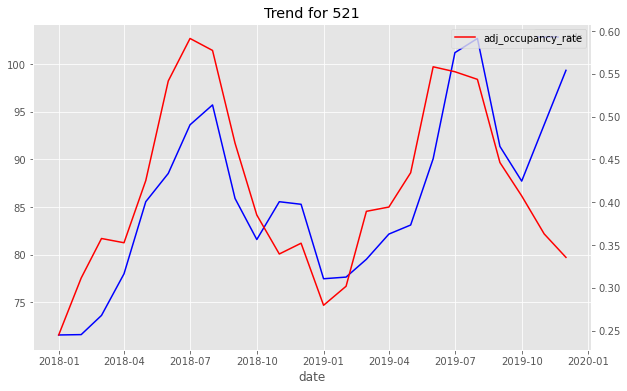

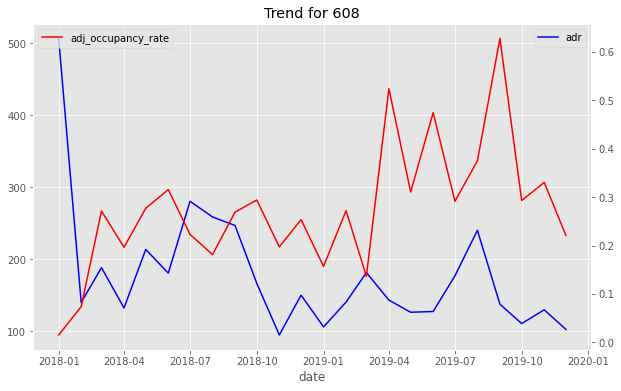

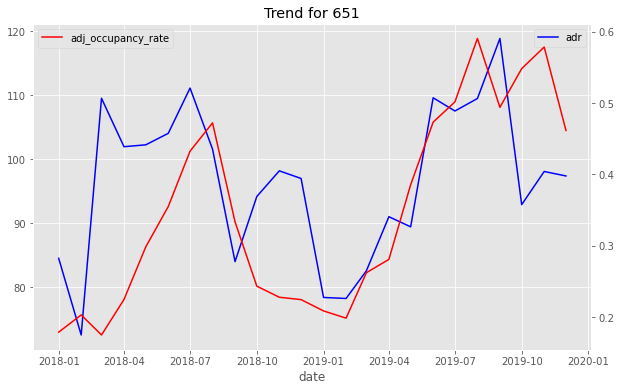

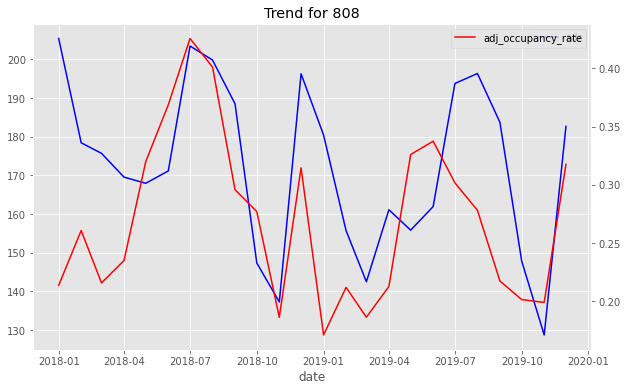

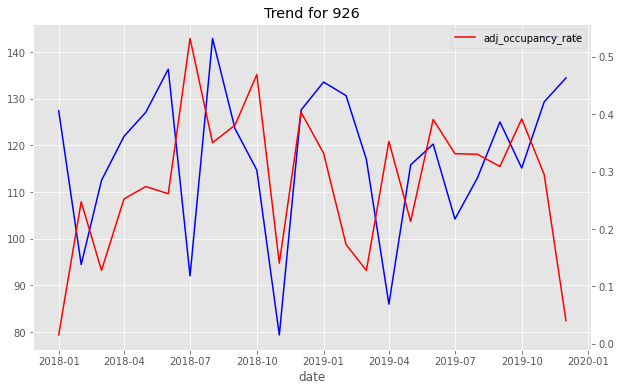

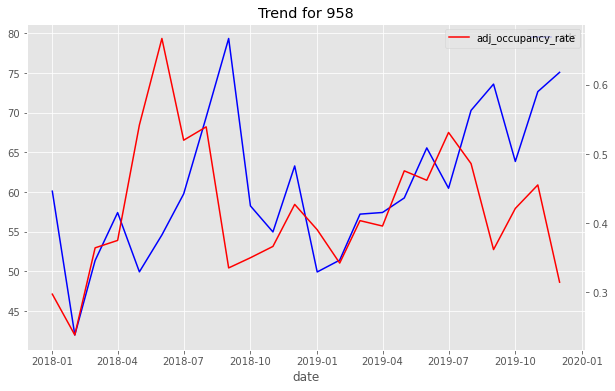

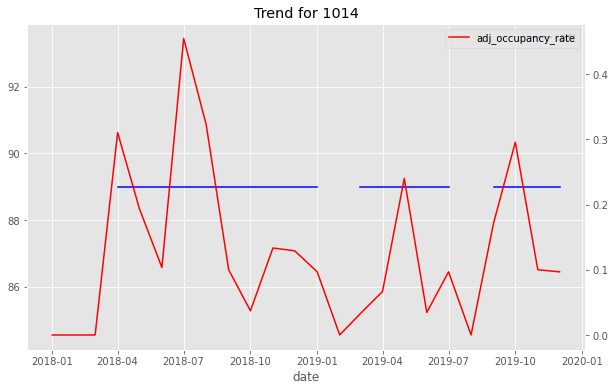

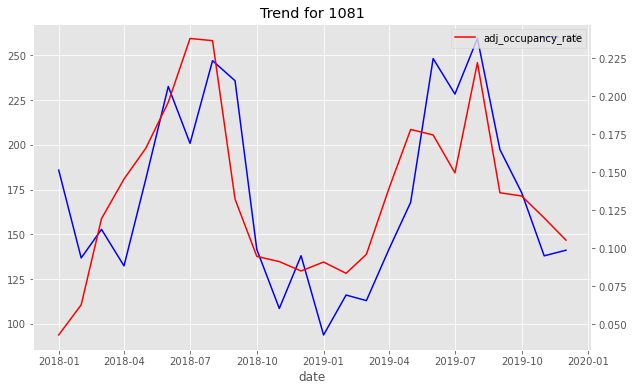

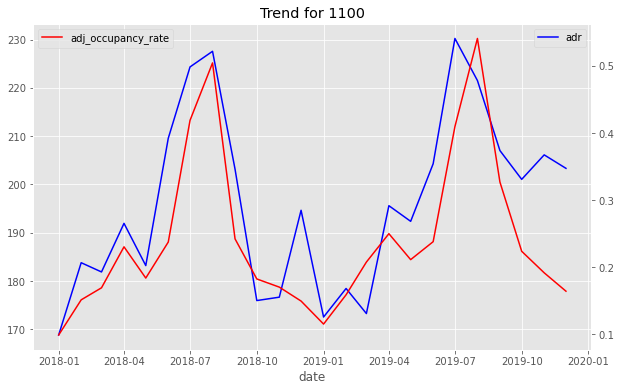

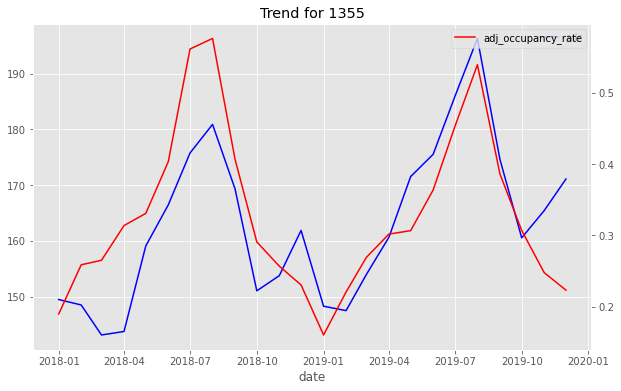

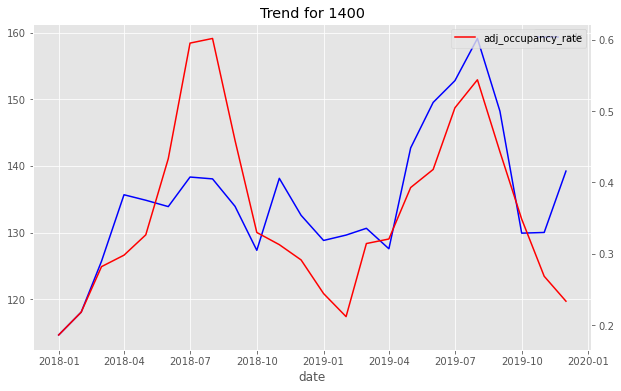

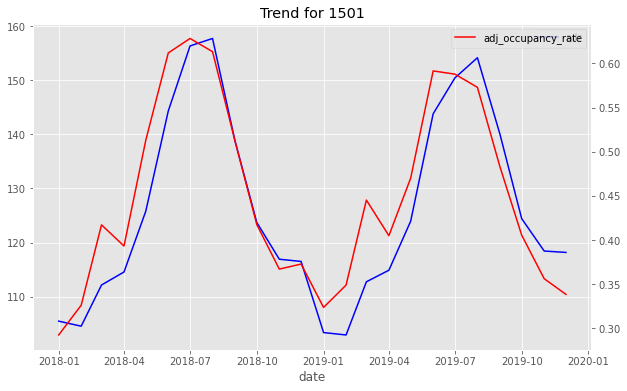

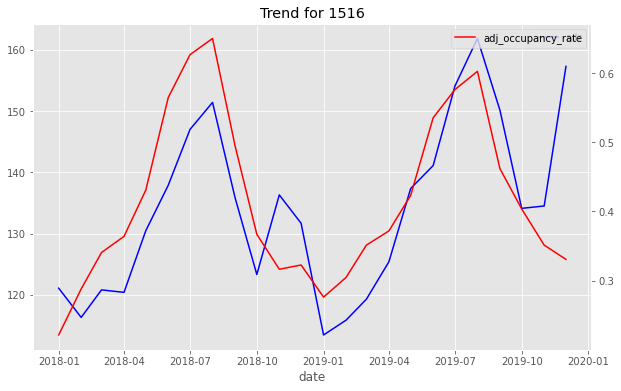

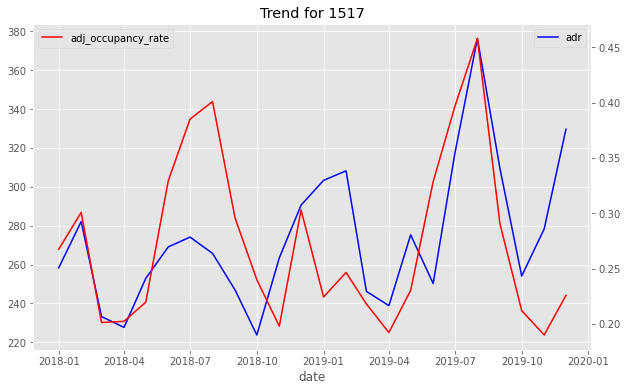

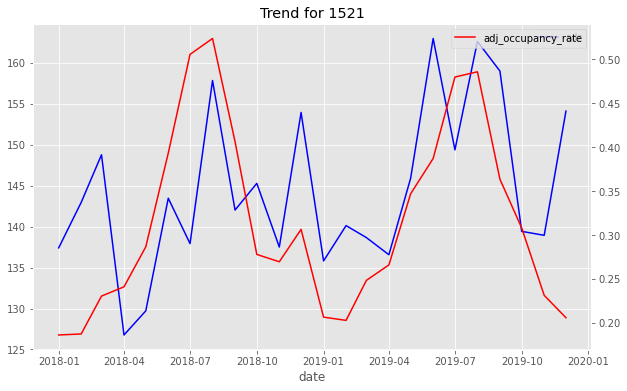

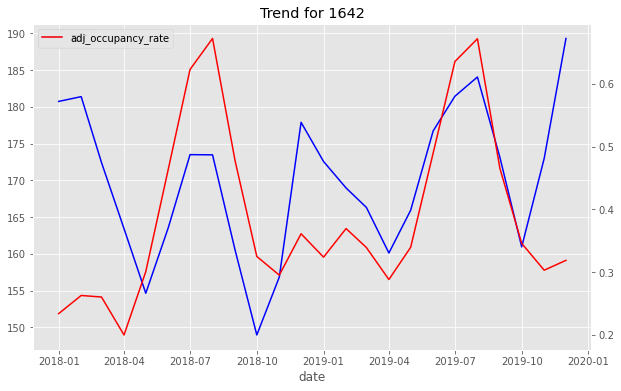

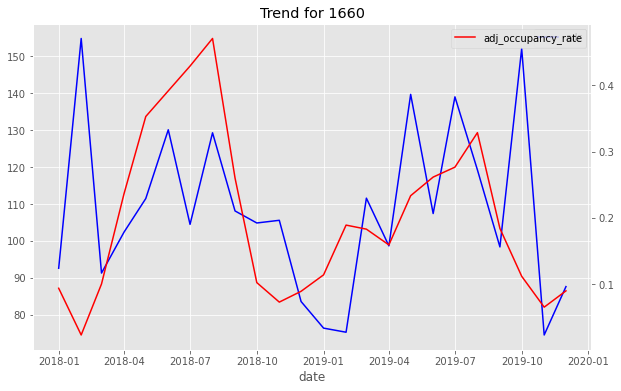

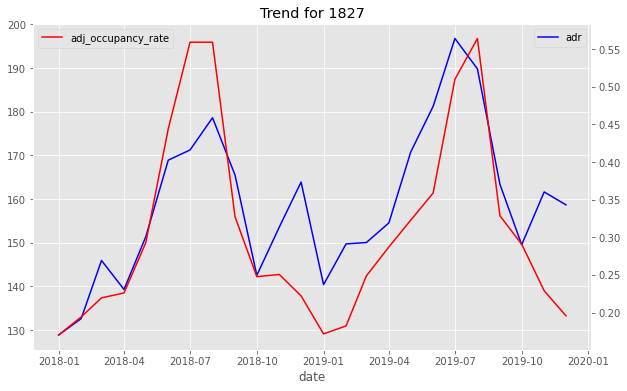

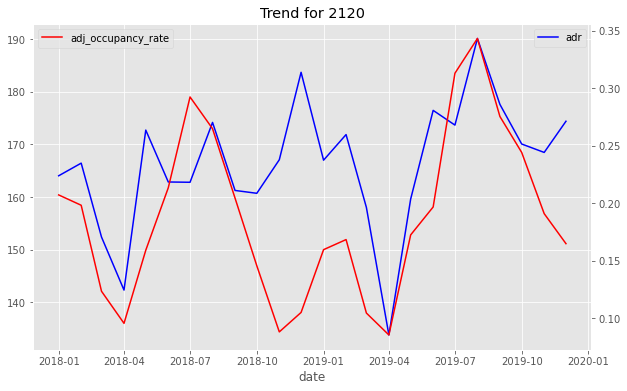

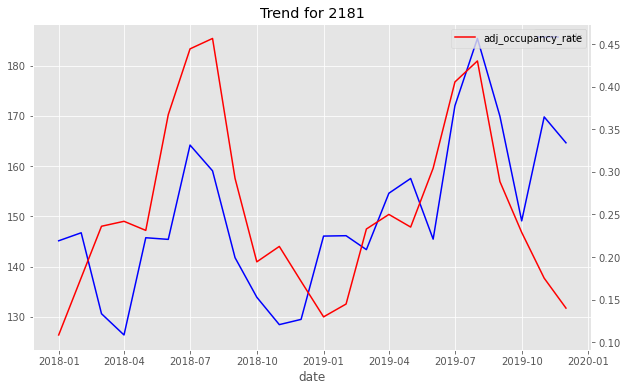

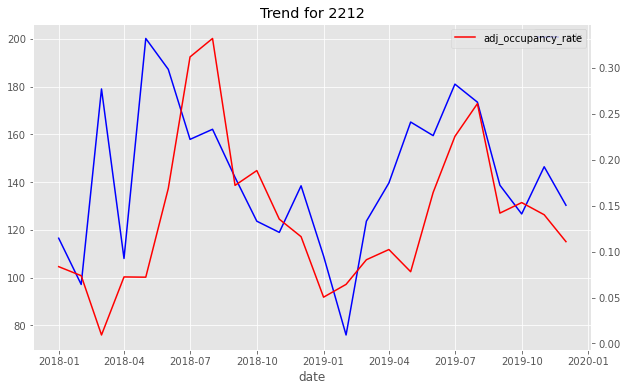

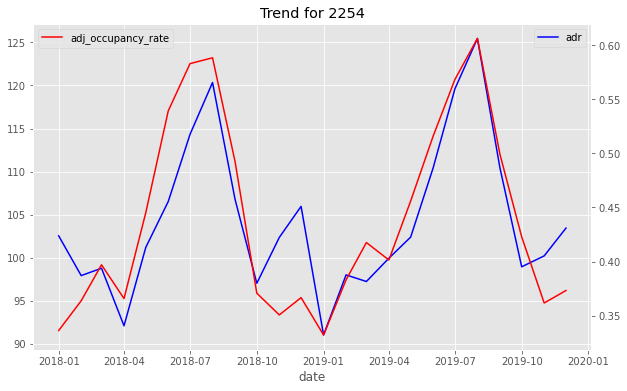

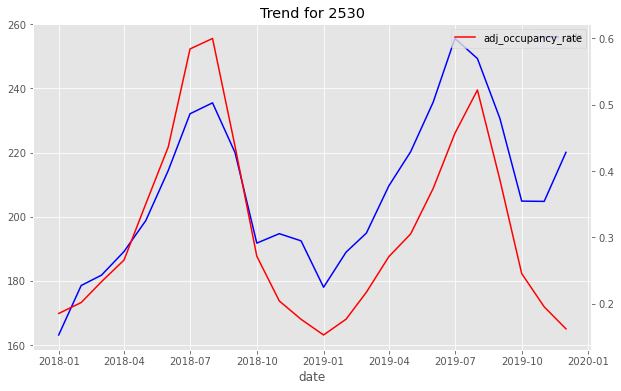

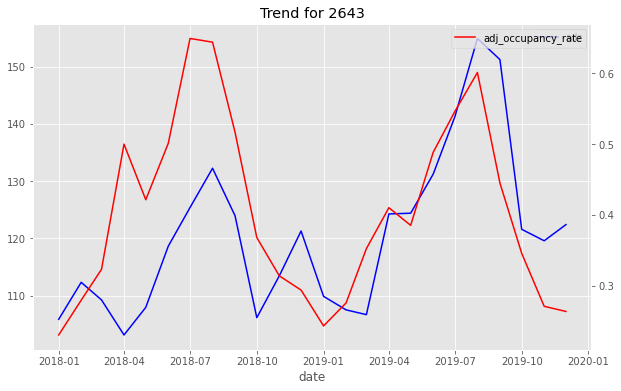

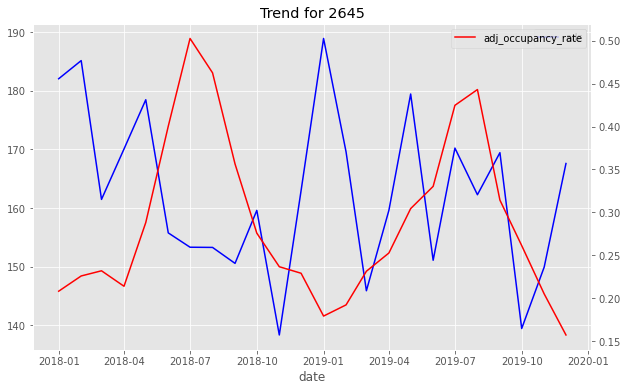

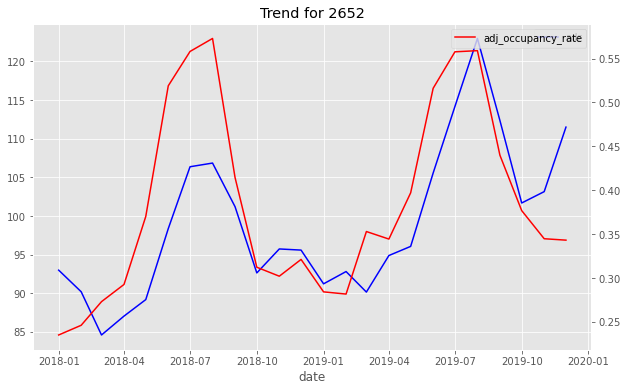

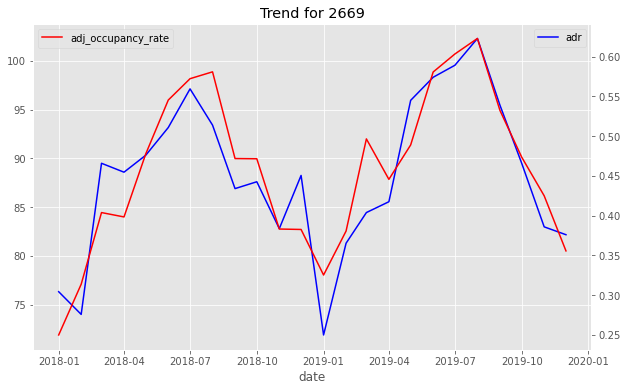

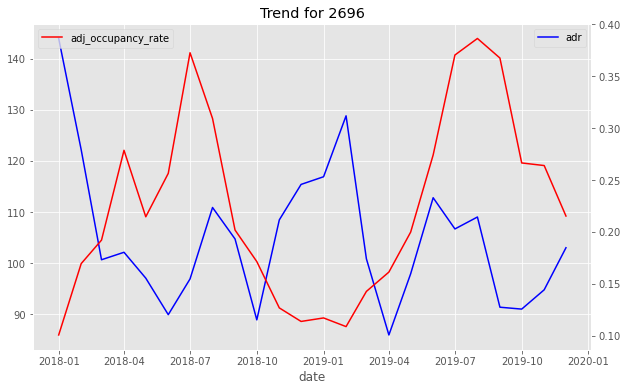

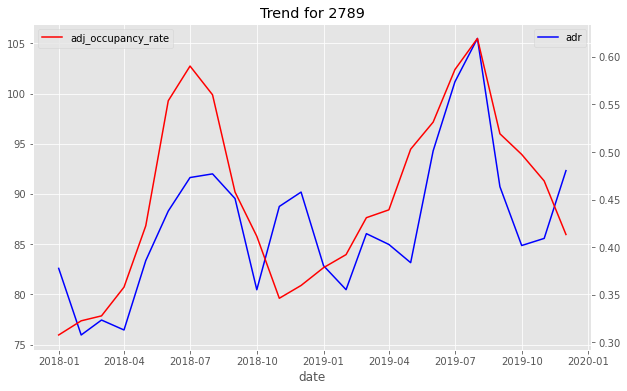

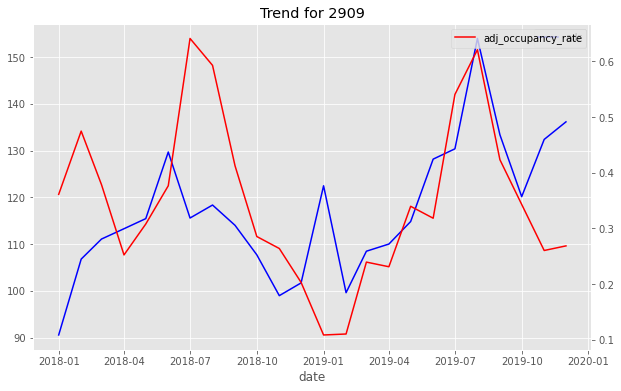

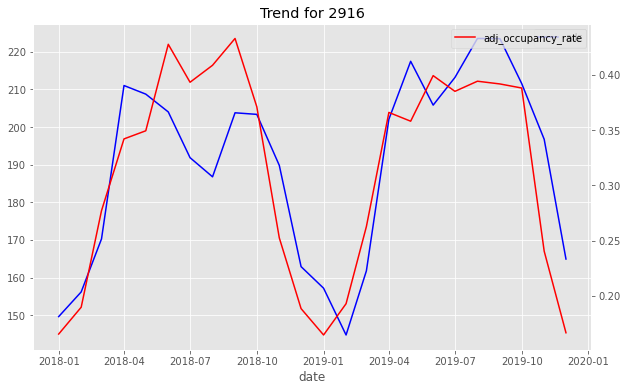

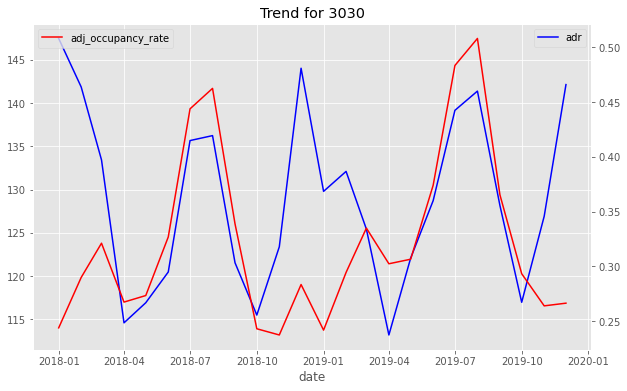

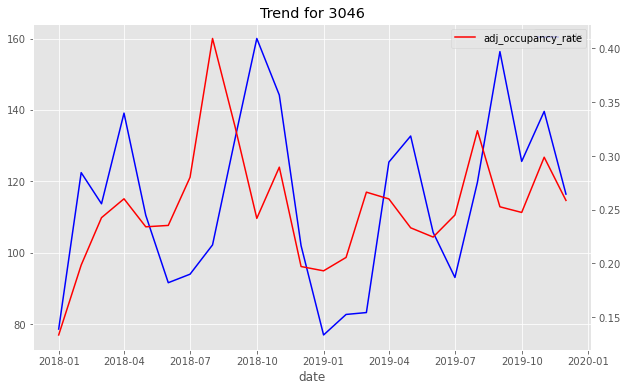

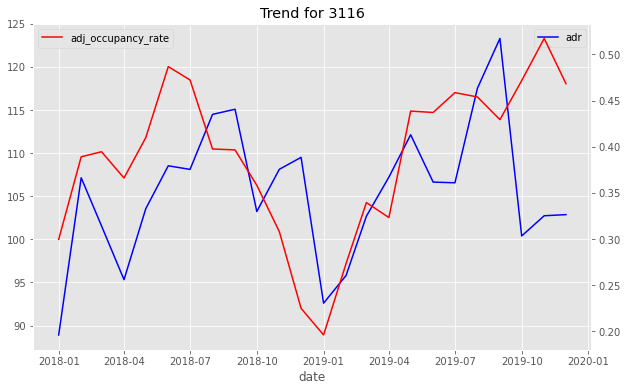

In [23]:
# plotting the trends based on the data avaialble
for county in seas_df_pd["county_id"].unique():
    fig, ax = plt.subplots()
    seas_df_pd.loc[seas_df_pd['county_id'] == county][['adr']].plot(ax=ax, style='b-', subplots=True)
    seas_df_pd.loc[seas_df_pd['county_id'] == county][['adj_occupancy_rate']].plot(ax=ax, style='r-', secondary_y=True, subplots=True)
    plt.title("Trend for " + str(county))






In [33]:
seas_df_pd

id  county_id  adj_revpan                  created_at  \
date                                                                   
2018-01-01  64317         11    0.475806  2021-05-18 18:21:51.601481   
2018-02-01  64318         11    3.839286  2021-05-18 18:21:51.601481   
2018-03-01  64319         11    7.584746  2021-05-18 18:21:51.601481   
2018-04-01  64320         11   22.990385  2021-05-18 18:21:51.601481   
2018-05-01  64321         11   44.534483  2021-05-18 18:21:51.601481   
...           ...        ...         ...                         ...   
2019-08-01  65248       3116   53.344659  2021-05-18 18:21:51.601481   
2019-09-01  65249       3116   52.937197  2021-05-18 18:21:51.601481   
2019-10-01  65250       3116   47.349789  2021-05-18 18:21:51.601481   
2019-11-01  65251       3116   53.142968  2021-05-18 18:21:51.601481   
2019-12-01  65252       3116   48.175225  2021-05-18 18:21:51.601481   

                            updated_at  adj_occupancy_rate  \
date                                                         
2018-01-01  2021-07-01 19:07:25.556519            0.008065   
2018-02-01  2021-07-01 19:07:25.556522            0.062500   
2018-03-01  2021-07-01 19:07:25.556524            0.127119   
2018-04-01  2021-07-01 19:07:25.556525            0.346154   
2018-05-01  2021-07-01 19:07:25.556527            0.508621   
...                                ...                 ...   
2019-08-01  2021-07-01 19:07:25.610796            0.453928   
2019-09-01    2021-07-01 19:07:25.6108            0.429346   
2019-10-01  2021-07-01 19:07:25.610803            0.471648   
2019-11-01  2021-07-01 19:07:25.610807            0.517288   
2019-12-01   2021-07-01 19:07:25.61081            0.468328   

            active_listings_count         adr  
date                                           
2018-01-01                      5   59.000000  
2018-02-01                      5   61.428571  
2018-03-01                      5   59.666667  
2018-04-01                      5   66.416667  
2018-05-01                      4   87.559322  
...                           ...         ...  
2019-08-01                    163  117.517964  
2019-09-01                    165  123.297207  
2019-10-01                    224  100.392268  
2019-11-01                    222  102.733759  
2019-12-01                    238  102.866347  

[936 rows x 8 columns]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39641D+00    |proj g|=  5.99048D-02

At iterate    5    f=  3.35887D+00    |proj g|=  7.62427D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   2.200D-06   3.359D+00
  F =   3.3587919960407246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


Text(0.5, 1.0, 'Train/Test split for BTC Data')

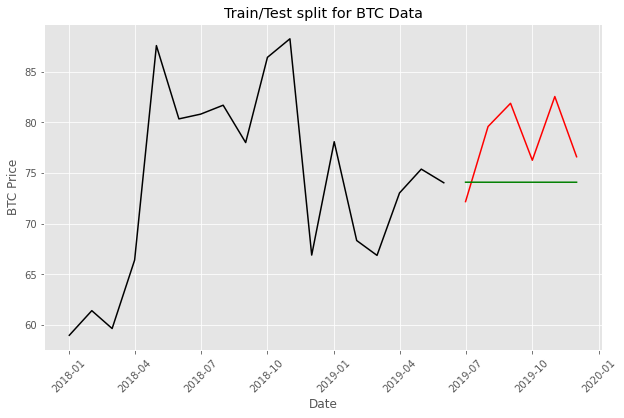

In [7]:
# Building seperate models of occ and adr as the scale for both of them is differnt and also I will be building seperate models for each county as each has its own 
# specific value 

# for columbia:
seas_df_pd_3116 = seas_df_pd[seas_df_pd["county_id"] == 11]
train = seas_df_pd_3116[seas_df_pd_3116.index < pd.to_datetime("2019-07-01", format='%Y-%m-%d')][["adr"]]
test = seas_df_pd_3116[seas_df_pd_3116.index >= pd.to_datetime("2019-07-01", format='%Y-%m-%d')][["adr"]]
y = train['adr']
ARMAmodel = SARIMAX(y, order = (1, 1, 1))
ARMAmodel = ARMAmodel.fit()
# train[['airbnb_average_adr_cents']].plot(color = "black")
# test[['airbnb_average_adr_cents']].plot(color = "red")
# plt.title("Trend for " + "county")
# # plt.ylabel('Adr Cents')
# # plt.xlabel('Date')
# # plt.title("Train/Test split for BTC Data")
# plt.show()


y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.5) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train[["adr"]], color = "black")
plt.plot(test[["adr"]], color = "red")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")




 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34203D+00    |proj g|=  3.62535D-01

At iterate    5    f=  3.25254D+00    |proj g|=  2.19452D-02

At iterate   10    f=  3.24949D+00    |proj g|=  1.87737D-03

At iterate   15    f=  3.24948D+00    |proj g|=  1.65636D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   7.047D-05   3.249D+00
  F =   3.2494791900495494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The root

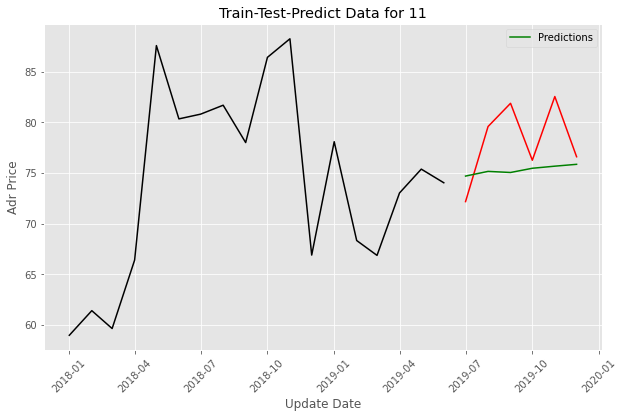

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33493D+00    |proj g|=  4.01638D-01

At iterate    5    f=  3.07194D+00    |proj g|=  1.48249D-02

At iterate   10    f=  3.06926D+00    |proj g|=  2.18915D-03

At iterate   15    f=  3.06860D+00    |proj g|=  1.51269D-03

At iterate   20    f=  3.06848D+00    |proj g|=  6.82497D-04

At iterate   25    f=  3.06847D+00    |proj g|=  1.30312D-04

At iterate   30    f=  3.06847D+00    |proj g|=  2.18205D-05

At iterate   35    f=  3.06847D+00    |proj g|=  4.02581D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


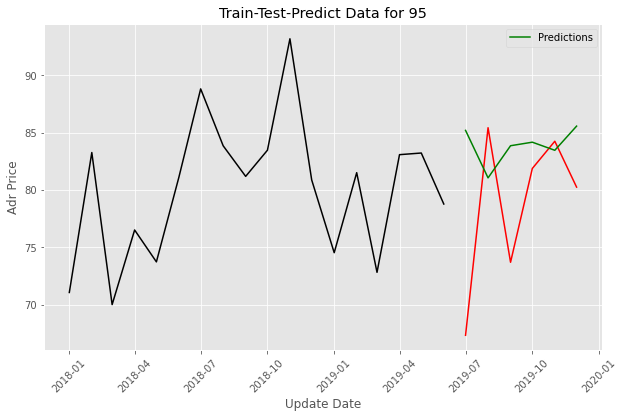

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16443D+00    |proj g|=  1.29020D-01

At iterate    5    f=  3.13188D+00    |proj g|=  8.76169D-02

At iterate   10    f=  3.12236D+00    |proj g|=  1.95730D-02

At iterate   15    f=  3.10180D+00    |proj g|=  4.20470D-02

At iterate   20    f=  3.09047D+00    |proj g|=  9.30674D-03

At iterate   25    f=  3.08914D+00    |proj g|=  2.39850D-03

At iterate   30    f=  3.08901D+00    |proj g|=  6.60786D-04

At iterate   35    f=  3.08899D+00    |proj g|=  3.69776D-04

At iterate   40    f=  3.08899D+00    |proj g|=  2.64396D-04

At iterate   45    f=  3.08899D+00    |proj g|=  1.96878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


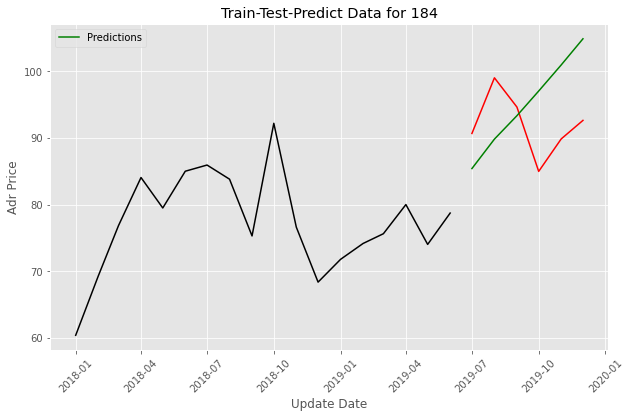

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32181D+00    |proj g|=  7.84225D-01

At iterate    5    f=  4.12882D+00    |proj g|=  1.39888D-01

At iterate   10    f=  4.05586D+00    |proj g|=  4.16103D-02

At iterate   15    f=  4.04338D+00    |proj g|=  4.21177D-02

At iterate   20    f=  4.02014D+00    |proj g|=  1.77730D-02

At iterate   25    f=  4.01012D+00    |proj g|=  1.99573D-02

At iterate   30    f=  4.00997D+00    |proj g|=  4.56821D-03

At iterate   35    f=  4.00943D+00    |proj g|=  4.18425D-03

At iterate   40    f=  4.00928D+00    |proj g|=  6.56229D-04

At iterate   45    f=  4.00925D+00    |proj g|=  8.90118D-05

At iterate   50    f=  4.00925D+00    |proj g|=  2.55180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


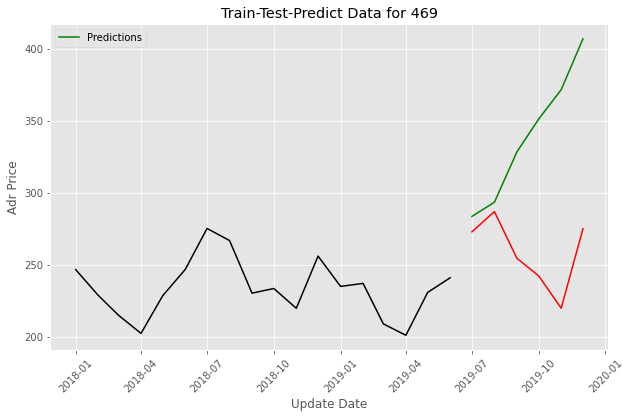

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09738D+00    |proj g|=  4.01883D-01

At iterate    5    f=  2.99944D+00    |proj g|=  8.64793D-02

At iterate   10    f=  2.96240D+00    |proj g|=  2.69175D-02

At iterate   15    f=  2.95570D+00    |proj g|=  5.24145D-03

At iterate   20    f=  2.95496D+00    |proj g|=  4.93853D-04

At iterate   25    f=  2.95486D+00    |proj g|=  9.91671D-04

At iterate   30    f=  2.95485D+00    |proj g|=  2.00963D-04

At iterate   35    f=  2.95485D+00    |proj g|=  1.06698D-04

At iterate   40    f=  2.95485D+00    |proj g|=  9.56475D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


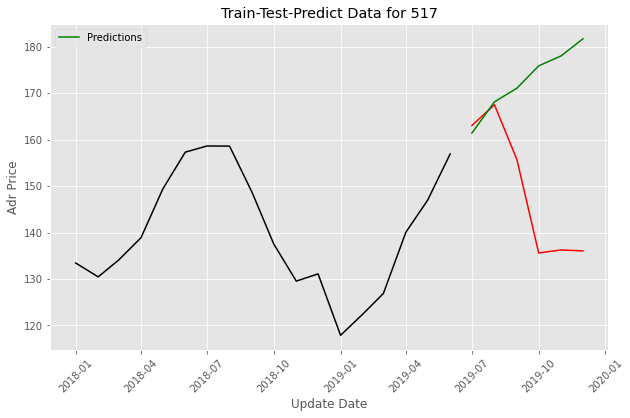

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65628D+00    |proj g|=  2.70248D-01

At iterate    5    f=  2.59809D+00    |proj g|=  8.35234D-02

At iterate   10    f=  2.59184D+00    |proj g|=  3.51574D-03

At iterate   15    f=  2.59170D+00    |proj g|=  7.57116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   8.971D-06   2.592D+00
  F =   2.5916986030290818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root

 This problem is unconstrained.


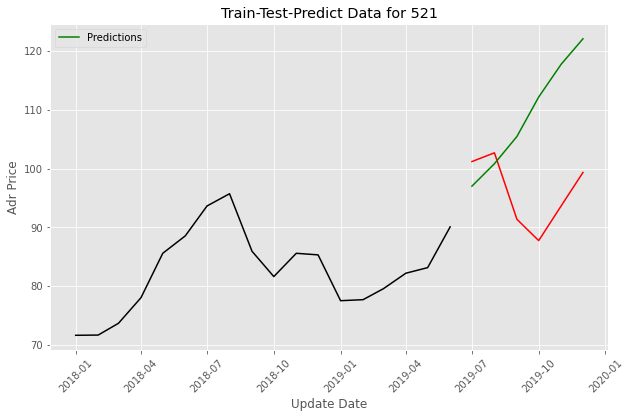

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82721D+00    |proj g|=  3.16308D+00

At iterate    5    f=  6.14616D+00    |proj g|=  1.83943D-01

At iterate   10    f=  6.04754D+00    |proj g|=  6.10540D-01

At iterate   15    f=  5.54546D+00    |proj g|=  2.80085D-01

At iterate   20    f=  5.38896D+00    |proj g|=  4.66994D-02

At iterate   25    f=  5.38158D+00    |proj g|=  3.73807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   

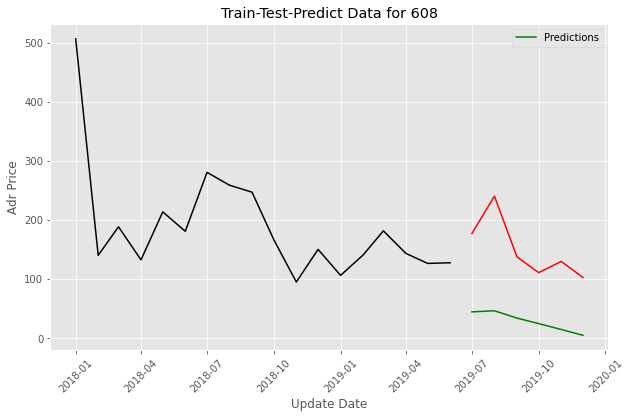

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76292D+00    |proj g|=  4.16333D-01

At iterate    5    f=  3.62145D+00    |proj g|=  2.29159D-02

At iterate   10    f=  3.60436D+00    |proj g|=  1.49412D-03

At iterate   15    f=  3.60349D+00    |proj g|=  5.62898D-03

At iterate   20    f=  3.60308D+00    |proj g|=  2.95675D-03

At iterate   25    f=  3.60302D+00    |proj g|=  2.48006D-04

At iterate   30    f=  3.60301D+00    |proj g|=  6.62534D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


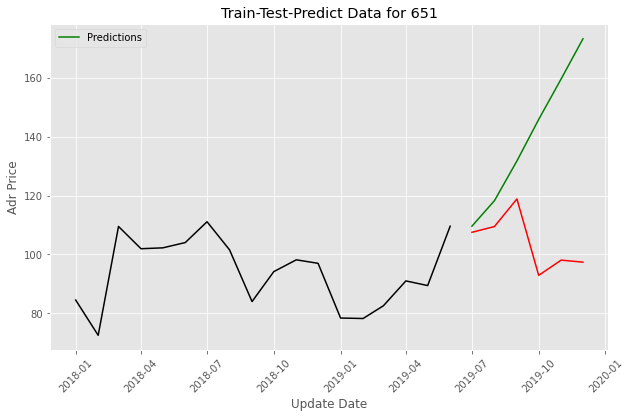

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59313D+00    |proj g|=  9.07358D-01

At iterate    5    f=  4.13282D+00    |proj g|=  3.58892D-02

At iterate   10    f=  4.00826D+00    |proj g|=  5.05413D-02

At iterate   15    f=  3.97011D+00    |proj g|=  1.34295D-02

At iterate   20    f=  3.94264D+00    |proj g|=  6.84209D-02

At iterate   25    f=  3.93410D+00    |proj g|=  1.80393D-03

At iterate   30    f=  3.93400D+00    |proj g|=  4.21099D-03

At iterate   35    f=  3.93377D+00    |proj g|=  1.53649D-03

At iterate   40    f=  3.93373D+00    |proj g|=  9.96293D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


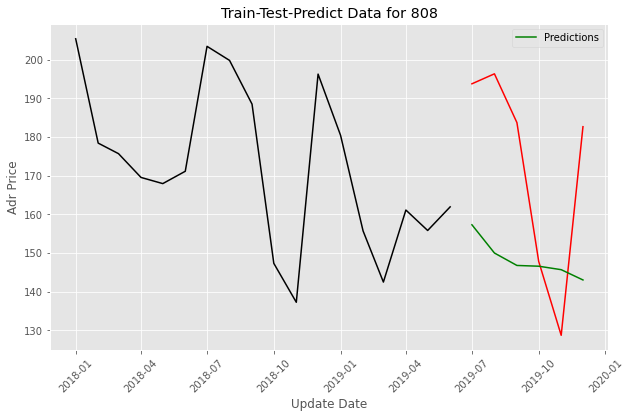

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.54948D+00    |proj g|=  7.30742D-01

At iterate    5    f=  4.21976D+00    |proj g|=  1.27018D-02

At iterate   10    f=  4.21266D+00    |proj g|=  1.64219D-02

At iterate   15    f=  4.20580D+00    |proj g|=  7.76876D-04

At iterate   20    f=  4.20519D+00    |proj g|=  4.65905D-04

At iterate   25    f=  4.20503D+00    |proj g|=  1.63555D-04

At iterate   30    f=  4.20501D+00    |proj g|=  3.63319D-04

At iterate   35    f=  4.20501D+00    |proj g|=  1.01926D-05

At iterate   40    f=  4.20501D+00    |proj g|=  3.80620D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


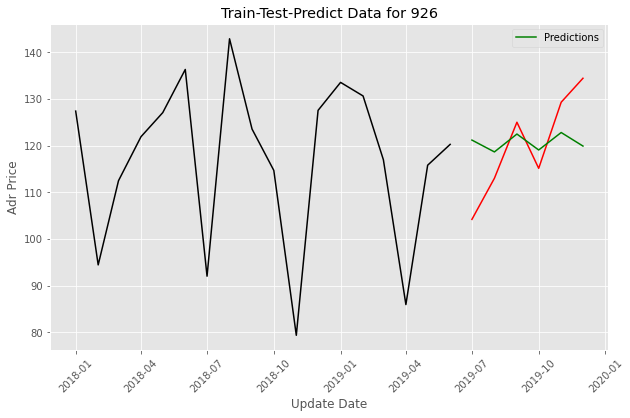

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41114D+00    |proj g|=  1.94977D+00

At iterate    5    f=  3.19211D+00    |proj g|=  4.64388D-02

At iterate   10    f=  3.16822D+00    |proj g|=  2.22749D-03

At iterate   15    f=  3.16703D+00    |proj g|=  1.56362D-02

At iterate   20    f=  3.16652D+00    |proj g|=  2.41588D-03

At iterate   25    f=  3.16646D+00    |proj g|=  4.62824D-04

At iterate   30    f=  3.16644D+00    |proj g|=  4.04647D-05

At iterate   35    f=  3.16644D+00    |proj g|=  1.12156D-04

At iterate   40    f=  3.16644D+00    |proj g|=  1.71167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

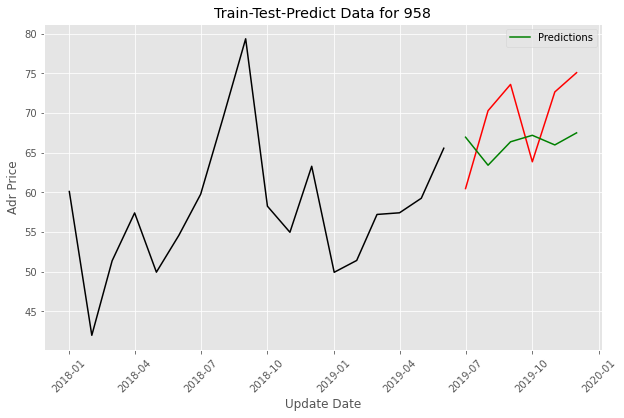

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69853D-01    |proj g|=  4.44089D-11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   4.441D-11   8.699D-01
  F =  0.86985267357631102     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the1014 is 1.247953213458455e-11
             adr  Predictions
date                         
2019-07-01  89.0         89.0
2019-08-01   NaN         89.0
2019-09-01

 This problem is unconstrained.


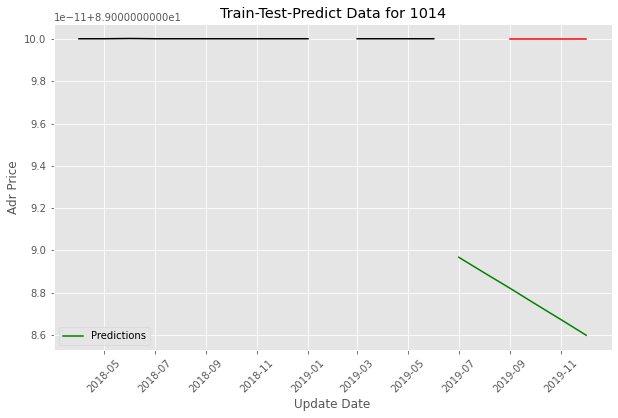

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.69899D+00    |proj g|=  1.67066D-01

At iterate    5    f=  4.69327D+00    |proj g|=  3.86339D-02

At iterate   10    f=  4.69021D+00    |proj g|=  7.58804D-03

At iterate   15    f=  4.68344D+00    |proj g|=  2.03195D-02

At iterate   20    f=  4.67785D+00    |proj g|=  2.27488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   1.100D-05   4.678D+00
  F =   4.6778485246262882     

CONVERG

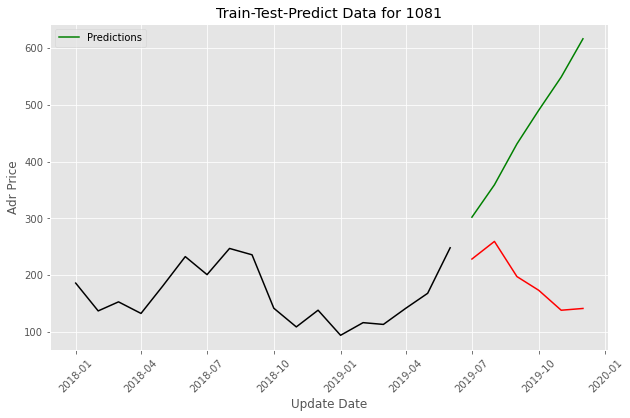

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81460D+00    |proj g|=  7.46951D-02

At iterate    5    f=  3.77720D+00    |proj g|=  2.78148D-02

At iterate   10    f=  3.72664D+00    |proj g|=  1.03285D-02

At iterate   15    f=  3.72506D+00    |proj g|=  1.25000D-02

At iterate   20    f=  3.72123D+00    |proj g|=  6.19101D-03

At iterate   25    f=  3.72032D+00    |proj g|=  1.96568D-03

At iterate   30    f=  3.72016D+00    |proj g|=  6.98675D-04

At iterate   35    f=  3.72008D+00    |proj g|=  2.59015D-04

At iterate   40    f=  3.72006D+00    |proj g|=  9.10363D-05

At iterate   45    f=  3.72005D+00    |proj g|=  2.40655D-04

At iterate   50    f=  3.72004D+00    |proj g|=  1.03294D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

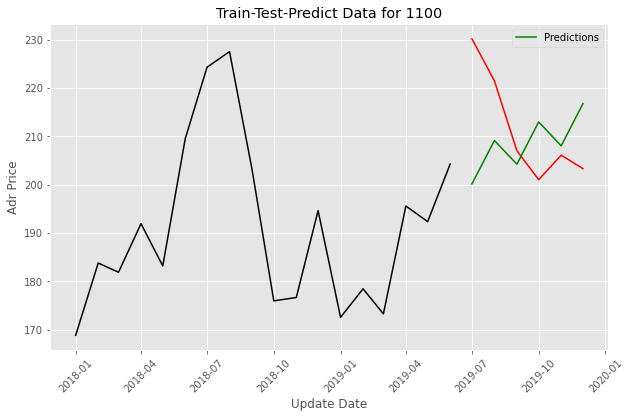

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19681D+00    |proj g|=  9.68831D-02

At iterate    5    f=  3.13848D+00    |proj g|=  1.37909D-02

At iterate   10    f=  3.12985D+00    |proj g|=  2.38862D-03

At iterate   15    f=  3.12912D+00    |proj g|=  8.14164D-03

At iterate   20    f=  3.12899D+00    |proj g|=  6.62469D-04

At iterate   25    f=  3.12898D+00    |proj g|=  2.55778D-04

At iterate   30    f=  3.12898D+00    |proj g|=  2.39322D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


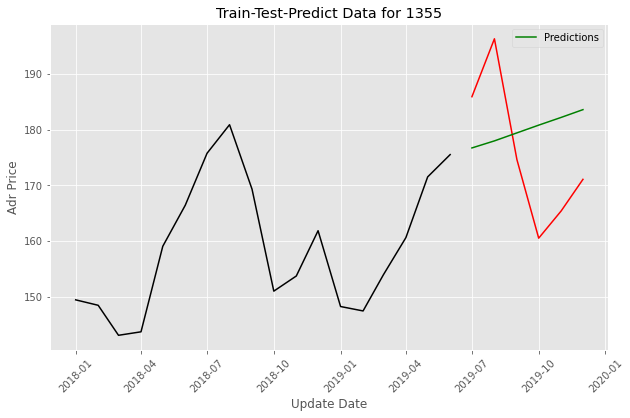

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.97504D+00    |proj g|=  1.16128D-01

At iterate    5    f=  2.93551D+00    |proj g|=  3.86378D-02

At iterate   10    f=  2.91559D+00    |proj g|=  1.26132D-02

At iterate   15    f=  2.91542D+00    |proj g|=  3.03700D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   8.603D-06   2.915D+00
  F =   2.9154149442907773     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root

 This problem is unconstrained.


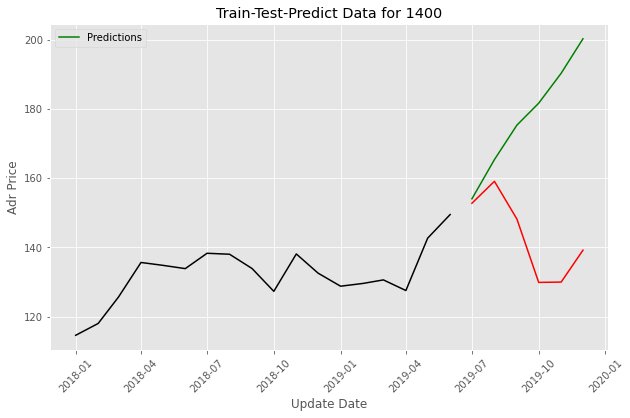

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27284D+00    |proj g|=  2.19206D-02

At iterate    5    f=  3.26530D+00    |proj g|=  2.84738D-02

At iterate   10    f=  3.26442D+00    |proj g|=  7.81394D-03



 This problem is unconstrained.


At iterate   15    f=  3.26422D+00    |proj g|=  4.95629D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   1.298D-06   3.264D+00
  F =   3.2642161002258470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the1501 is 81.00295522534162
                   adr  Predictions
date                               
2019-07-01  150.460980   162.281579
2019-08-01  154.191373   177.111188
2019-09-01  140.063086   193.708037
2019-10-01  124.422097   211.850880
2019-11-01  118.429562   228.589830
2019-12-01  118.172987   244.849625


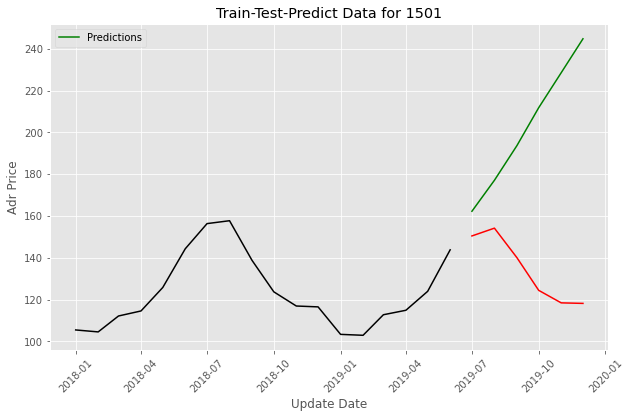

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51246D+00    |proj g|=  7.17051D-01


 This problem is unconstrained.



At iterate    5    f=  3.23408D+00    |proj g|=  4.41332D-02

At iterate   10    f=  3.21464D+00    |proj g|=  7.77323D-03

At iterate   15    f=  3.21064D+00    |proj g|=  1.33565D-03

At iterate   20    f=  3.21030D+00    |proj g|=  2.27604D-03

At iterate   25    f=  3.21025D+00    |proj g|=  5.95505D-04

At iterate   30    f=  3.21024D+00    |proj g|=  1.33369D-04

At iterate   35    f=  3.21024D+00    |proj g|=  8.19269D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     37      1     0     0   8.193D-05   3.210D+00
  F =   3.2102415039389629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

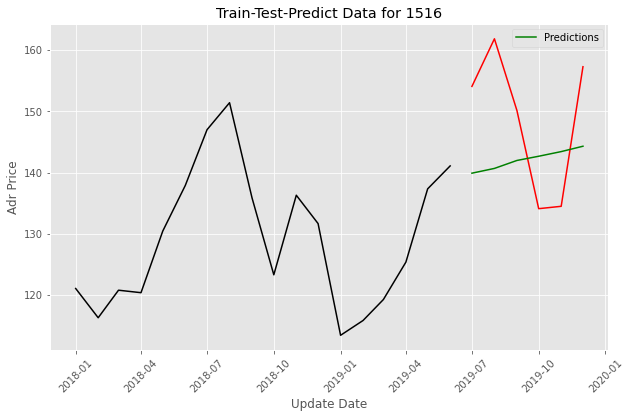

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.49307D+00    |proj g|=  5.01655D-01

At iterate    5    f=  4.21722D+00    |proj g|=  1.32050D-02


 This problem is unconstrained.



At iterate   10    f=  4.17241D+00    |proj g|=  4.62716D-02

At iterate   15    f=  4.16699D+00    |proj g|=  3.45611D-04

At iterate   20    f=  4.16684D+00    |proj g|=  4.38341D-04

At iterate   25    f=  4.16683D+00    |proj g|=  2.81722D-04

At iterate   30    f=  4.16681D+00    |proj g|=  1.56580D-04

At iterate   35    f=  4.16681D+00    |proj g|=  7.54268D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     42      1     0     0   7.543D-06   4.167D+00
  F =   4.1668123387373397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the1517 is 74.073433

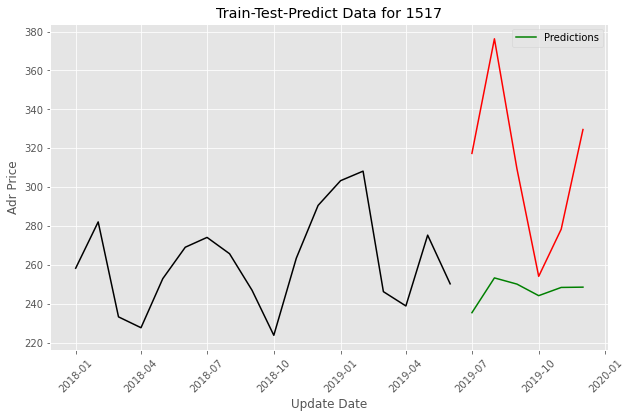

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61859D+00    |proj g|=  2.44413D+00

At iterate    5    f=  3.52592D+00    |proj g|=  7.93263D-02

At iterate   10    f=  3.49685D+00    |proj g|=  2.58696D-02

At iterate   15    f=  3.49512D+00    |proj g|=  3.67989D-03

At iterate   20    f=  3.49331D+00    |proj g|=  1.92247D-03

At iterate   25    f=  3.49276D+00    |proj g|=  9.48613D-04

At iterate   30    f=  3.49252D+00    |proj g|=  2.37595D-04

At iterate   35    f=  3.49247D+00    |proj g|=  4.41468D-04

At iterate   40    f=  3.49244D+00    |proj g|=  3.02276D-05

At iterate   45    f=  3.49243D+00    |proj g|=  2.35838D-04

At iterate   50    f=  3.49243D+00    |proj g|=  2.76854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


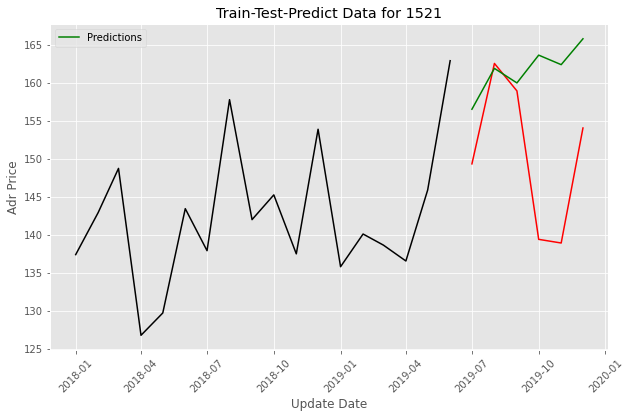

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.59290D+00    |proj g|=  8.49310D-01

At iterate    5    f=  3.19474D+00    |proj g|=  1.02099D-01

At iterate   10    f=  3.08109D+00    |proj g|=  4.09718D-02

At iterate   15    f=  2.99829D+00    |proj g|=  3.48050D-02

At iterate   20    f=  2.97120D+00    |proj g|=  1.60938D-02

At iterate   25    f=  2.96956D+00    |proj g|=  5.66021D-03

At iterate   30    f=  2.96864D+00    |proj g|=  7.54766D-03

At iterate   35    f=  2.96852D+00    |proj g|=  3.32170D-04

At iterate   40    f=  2.96850D+00    |proj g|=  2.73640D-04

At iterate   45    f=  2.96850D+00    |proj g|=  4.21242D-05

At iterate   50    f=  2.96850D+00    |proj g|=  3.56487D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

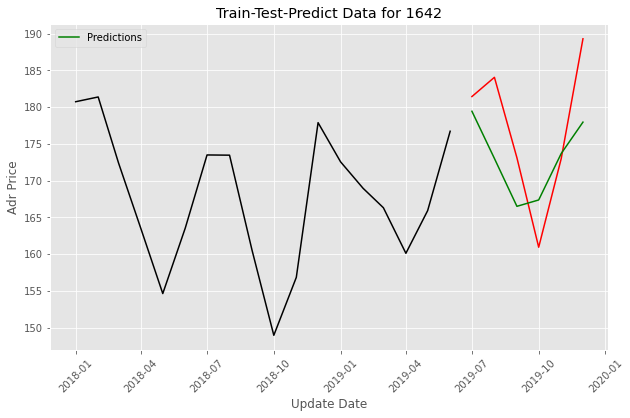

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32300D+00    |proj g|=  3.15217D-01

At iterate    5    f=  4.17436D+00    |proj g|=  1.30027D-02

At iterate   10    f=  4.16566D+00    |proj g|=  1.78871D-03

At iterate   15    f=  4.16521D+00    |proj g|=  1.97920D-03

At iterate   20    f=  4.16514D+00    |proj g|=  2.16643D-03

At iterate   25    f=  4.16503D+00    |proj g|=  5.71485D-04

At iterate   30    f=  4.16502D+00    |proj g|=  1.88987D-04

At iterate   35    f=  4.16501D+00    |proj g|=  5.72749D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

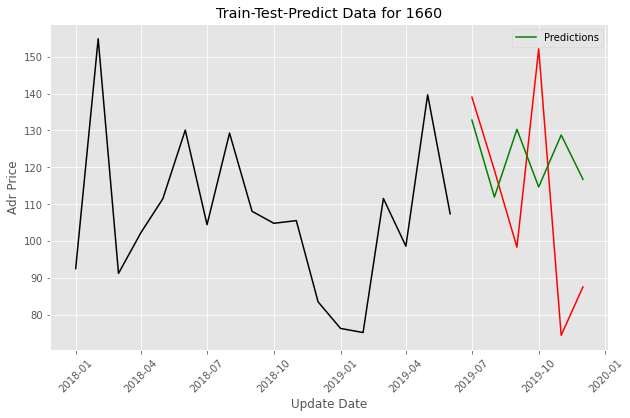

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55141D+00    |proj g|=  3.90878D-02

At iterate    5    f=  3.54872D+00    |proj g|=  1.44484D-02

At iterate   10    f=  3.54273D+00    |proj g|=  8.03927D-03

At iterate   15    f=  3.53989D+00    |proj g|=  4.52892D-03

At iterate   20    f=  3.53898D+00    |proj g|=  6.99950D-03

At iterate   25    f=  3.53867D+00    |proj g|=  7.12084D-04

At iterate   30    f=  3.53860D+00    |proj g|=  5.19371D-04

At iterate   35    f=  3.53860D+00    |proj g|=  1.19709D-04

At iterate   40    f=  3.53860D+00    |proj g|=  7.63820D-05

At iterate   45    f=  3.53860D+00    |proj g|=  1.19066D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

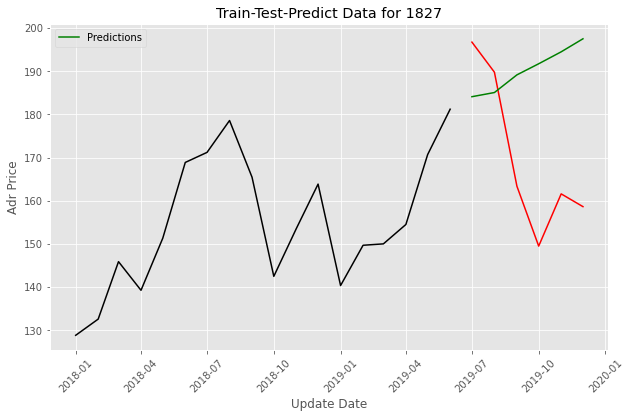

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00807D+00    |proj g|=  6.63134D-01

At iterate    5    f=  3.72492D+00    |proj g|=  1.84942D-02

At iterate   10    f=  3.69461D+00    |proj g|=  3.23451D-02

At iterate   15    f=  3.69305D+00    |proj g|=  7.18359D-03

At iterate   20    f=  3.69206D+00    |proj g|=  3.86779D-03

At iterate   25    f=  3.69194D+00    |proj g|=  1.62695D-03

At iterate   30    f=  3.69192D+00    |proj g|=  2.55316D-04

At iterate   35    f=  3.69192D+00    |proj g|=  3.30791D-05

At iterate   40    f=  3.69192D+00    |proj g|=  6.33841D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

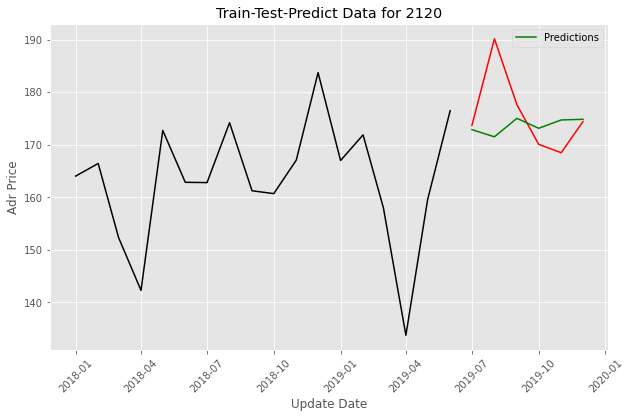

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69950D+00    |proj g|=  6.47796D-01

At iterate    5    f=  3.47022D+00    |proj g|=  3.00682D-02

At iterate   10    f=  3.45414D+00    |proj g|=  2.24210D-02

At iterate   15    f=  3.45313D+00    |proj g|=  2.34067D-03

At iterate   20    f=  3.45261D+00    |proj g|=  9.13495D-04

At iterate   25    f=  3.45253D+00    |proj g|=  3.83928D-04

At iterate   30    f=  3.45252D+00    |proj g|=  1.76802D-04

At iterate   35    f=  3.45252D+00    |proj g|=  2.30891D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

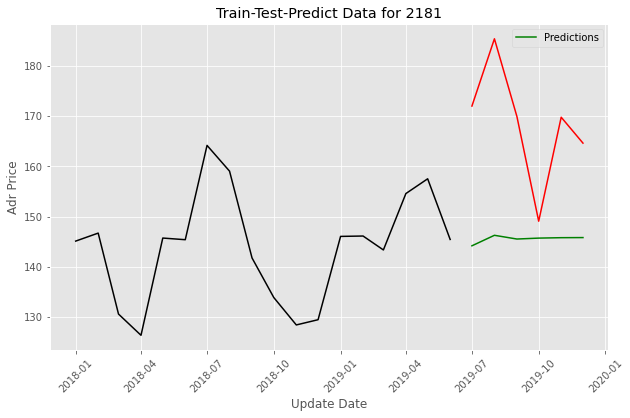

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32262D+00    |proj g|=  1.64693D+00

At iterate    5    f=  4.58514D+00    |proj g|=  2.58744D-02

At iterate   10    f=  4.53492D+00    |proj g|=  1.16844D-02

At iterate   15    f=  4.53110D+00    |proj g|=  1.45583D-03

At iterate   20    f=  4.52880D+00    |proj g|=  1.51390D-02

At iterate   25    f=  4.52823D+00    |proj g|=  3.36052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   

 This problem is unconstrained.


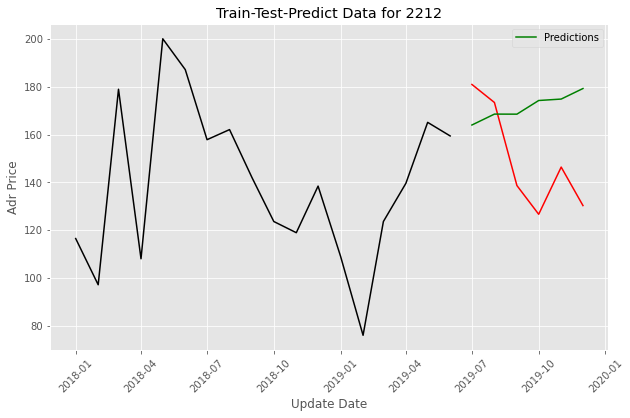

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17669D+00    |proj g|=  1.26034D-01

At iterate    5    f=  3.15150D+00    |proj g|=  3.05912D-03

At iterate   10    f=  3.14608D+00    |proj g|=  3.60530D-03

At iterate   15    f=  3.14433D+00    |proj g|=  3.32079D-03

At iterate   20    f=  3.14397D+00    |proj g|=  6.65405D-04

At iterate   25    f=  3.14395D+00    |proj g|=  3.36940D-05

At iterate   30    f=  3.14394D+00    |proj g|=  2.28252D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

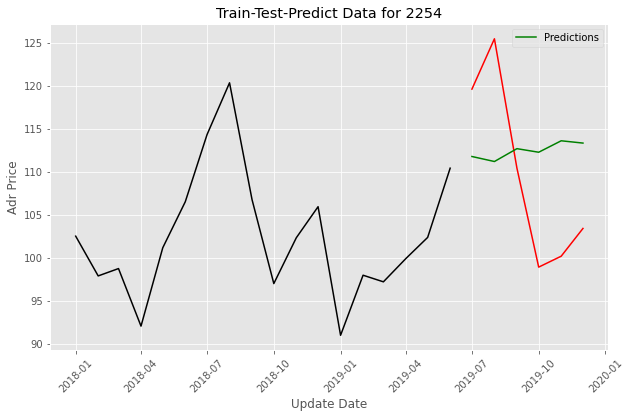

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57747D+00    |proj g|=  2.38733D-01

At iterate    5    f=  3.49421D+00    |proj g|=  9.00392D-02

At iterate   10    f=  3.46554D+00    |proj g|=  5.44560D-03

At iterate   15    f=  3.46327D+00    |proj g|=  2.83866D-03

At iterate   20    f=  3.46273D+00    |proj g|=  1.03459D-03

At iterate   25    f=  3.46265D+00    |proj g|=  2.23177D-04

At iterate   30    f=  3.46264D+00    |proj g|=  1.24231D-04

At iterate   35    f=  3.46264D+00    |proj g|=  7.59528D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

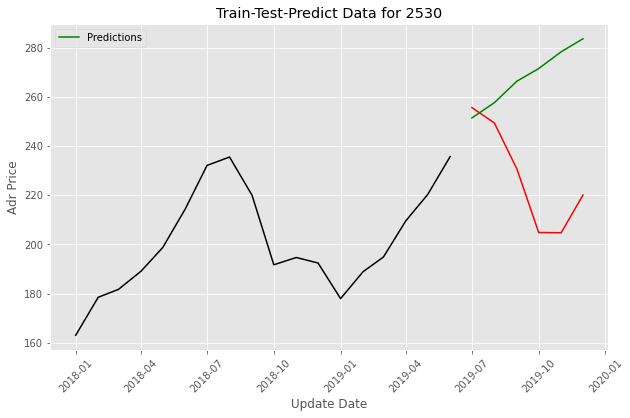

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66830D+00    |proj g|=  8.69672D-01

At iterate    5    f=  3.27364D+00    |proj g|=  2.65813D-02

At iterate   10    f=  3.24895D+00    |proj g|=  3.74839D-02

At iterate   15    f=  3.23620D+00    |proj g|=  4.25108D-03

At iterate   20    f=  3.23412D+00    |proj g|=  3.73271D-03

At iterate   25    f=  3.23380D+00    |proj g|=  2.21266D-03

At iterate   30    f=  3.23377D+00    |proj g|=  9.22296D-04

At iterate   35    f=  3.23377D+00    |proj g|=  9.23662D-05

At iterate   40    f=  3.23377D+00    |proj g|=  1.17732D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


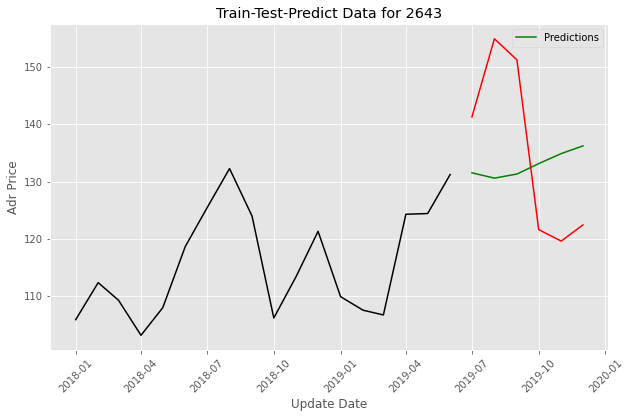

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78323D+00    |proj g|=  6.89630D-02

At iterate    5    f=  3.76392D+00    |proj g|=  5.56068D-02

At iterate   10    f=  3.68983D+00    |proj g|=  8.58123D-02

At iterate   15    f=  3.67965D+00    |proj g|=  3.69005D-03

At iterate   20    f=  3.67844D+00    |proj g|=  1.19689D-02

At iterate   25    f=  3.67775D+00    |proj g|=  7.48538D-03

At iterate   30    f=  3.67764D+00    |proj g|=  4.15644D-04

At iterate   35    f=  3.67763D+00    |proj g|=  2.94119D-04

At iterate   40    f=  3.67763D+00    |proj g|=  1.70522D-04

At iterate   45    f=  3.67763D+00    |proj g|=  6.63164D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

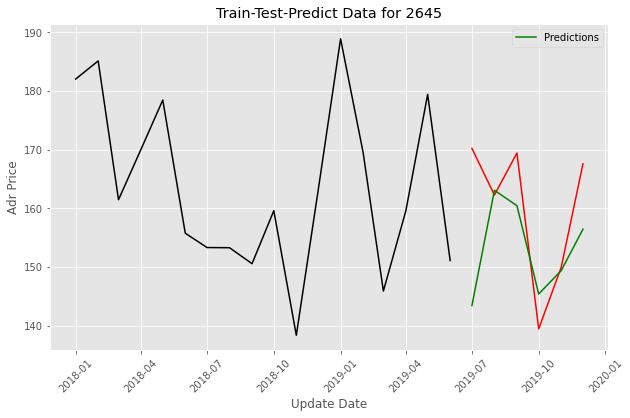

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86598D+00    |proj g|=  2.94678D-01

At iterate    5    f=  2.78602D+00    |proj g|=  3.87463D-02

At iterate   10    f=  2.76479D+00    |proj g|=  6.55470D-03

At iterate   15    f=  2.76220D+00    |proj g|=  4.25293D-03

At iterate   20    f=  2.76183D+00    |proj g|=  1.04172D-03

At iterate   25    f=  2.76141D+00    |proj g|=  6.15653D-04

At iterate   30    f=  2.76135D+00    |proj g|=  7.14416D-05

At iterate   35    f=  2.76133D+00    |proj g|=  1.12955D-04

At iterate   40    f=  2.76132D+00    |proj g|=  3.39673D-04

At iterate   45    f=  2.76132D+00    |proj g|=  5.49141D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


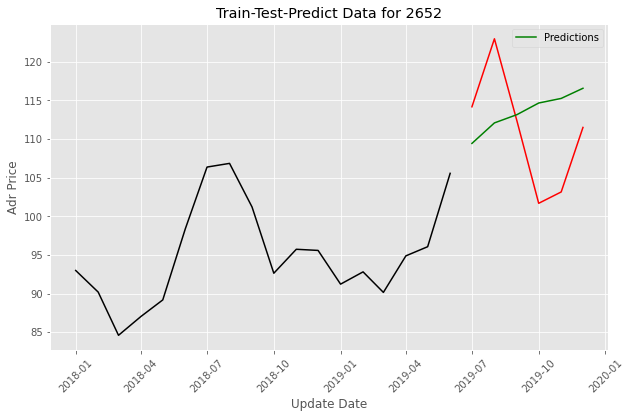

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00647D+00    |proj g|=  3.15134D-02

At iterate    5    f=  2.99007D+00    |proj g|=  4.65710D-03

At iterate   10    f=  2.98781D+00    |proj g|=  1.45239D-03

At iterate   15    f=  2.98750D+00    |proj g|=  2.17702D-04

At iterate   20    f=  2.98747D+00    |proj g|=  1.86701D-04

At iterate   25    f=  2.98746D+00    |proj g|=  1.65782D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     38      1     0     0   

 This problem is unconstrained.


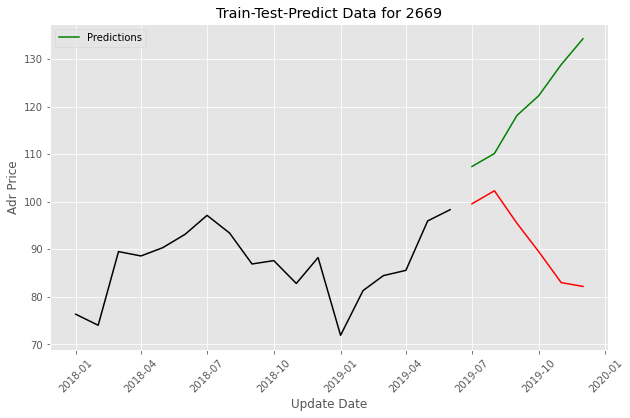

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30907D+00    |proj g|=  1.19704D+00

At iterate    5    f=  3.57417D+00    |proj g|=  2.47372D-02

At iterate   10    f=  3.56702D+00    |proj g|=  9.90037D-03

At iterate   15    f=  3.56623D+00    |proj g|=  3.34323D-03

At iterate   20    f=  3.56617D+00    |proj g|=  4.89631D-04

At iterate   25    f=  3.56611D+00    |proj g|=  4.82630D-03

At iterate   30    f=  3.56603D+00    |proj g|=  1.39948D-03

At iterate   35    f=  3.56602D+00    |proj g|=  9.53239D-05

At iterate   40    f=  3.56602D+00    |proj g|=  7.35469D-05

At iterate   45    f=  3.56602D+00    |proj g|=  9.84866D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

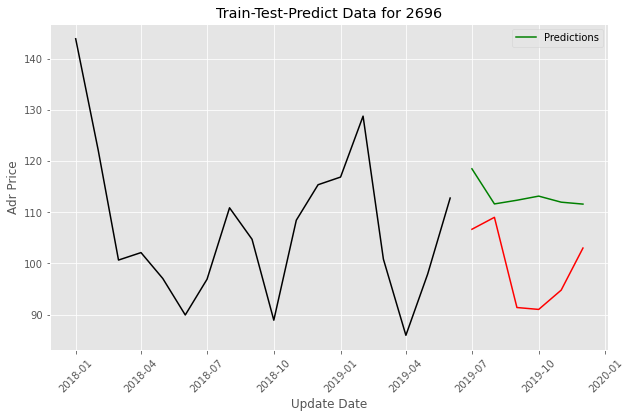

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95331D+00    |proj g|=  2.26220D-01

At iterate    5    f=  2.89288D+00    |proj g|=  3.01062D-02

At iterate   10    f=  2.85403D+00    |proj g|=  7.35242D-02

At iterate   15    f=  2.83609D+00    |proj g|=  1.50731D-02

At iterate   20    f=  2.83340D+00    |proj g|=  2.82309D-03

At iterate   25    f=  2.83312D+00    |proj g|=  1.42281D-03

At iterate   30    f=  2.83308D+00    |proj g|=  8.71800D-04

At iterate   35    f=  2.83307D+00    |proj g|=  2.48032D-04

At iterate   40    f=  2.83307D+00    |proj g|=  1.22207D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

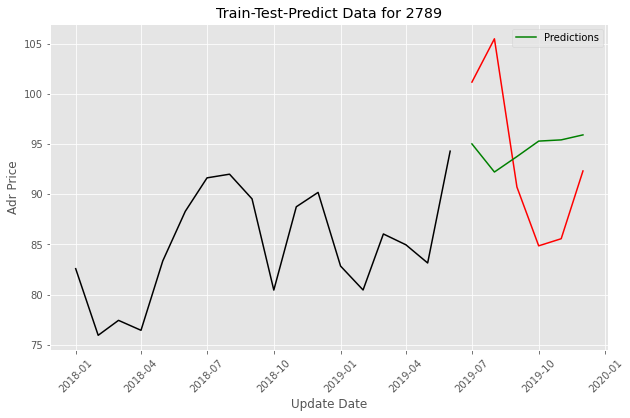

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.98359D+00    |proj g|=  1.21229D+00

At iterate    5    f=  3.44292D+00    |proj g|=  2.45829D-02

At iterate   10    f=  3.43109D+00    |proj g|=  2.78330D-02

At iterate   15    f=  3.41634D+00    |proj g|=  9.38236D-03

At iterate   20    f=  3.41513D+00    |proj g|=  7.60482D-03

At iterate   25    f=  3.41506D+00    |proj g|=  1.15811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   

 This problem is unconstrained.


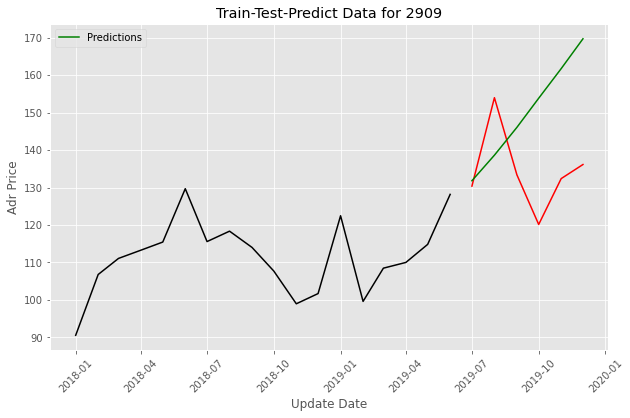

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86075D+00    |proj g|=  2.44587D-01

At iterate    5    f=  3.82618D+00    |proj g|=  5.81326D-02

At iterate   10    f=  3.80472D+00    |proj g|=  4.51777D-03

At iterate   15    f=  3.79880D+00    |proj g|=  2.43459D-02

At iterate   20    f=  3.79760D+00    |proj g|=  2.39206D-03

At iterate   25    f=  3.79751D+00    |proj g|=  2.86719D-04

At iterate   30    f=  3.79725D+00    |proj g|=  9.47786D-03

At iterate   35    f=  3.79711D+00    |proj g|=  9.16203D-04

At iterate   40    f=  3.79709D+00    |proj g|=  2.21043D-04

At iterate   45    f=  3.79709D+00    |proj g|=  1.08043D-04

At iterate   50    f=  3.79709D+00    |proj g|=  1.00211D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


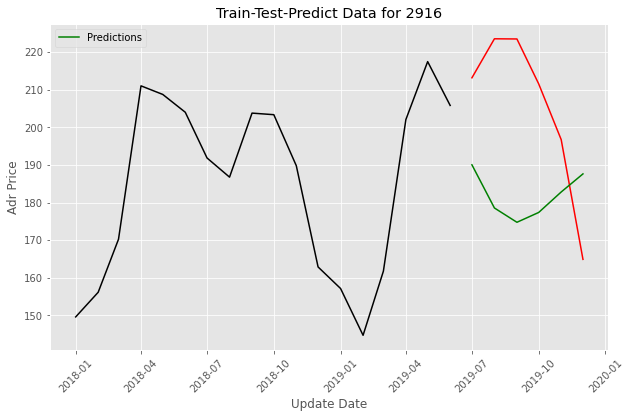

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84292D+00    |proj g|=  5.97045D-01

At iterate    5    f=  3.46710D+00    |proj g|=  3.25154D-02

At iterate   10    f=  3.44296D+00    |proj g|=  1.58821D-02

At iterate   15    f=  3.43841D+00    |proj g|=  4.05710D-03

At iterate   20    f=  3.43787D+00    |proj g|=  1.99294D-04

At iterate   25    f=  3.43782D+00    |proj g|=  7.63861D-05

At iterate   30    f=  3.43782D+00    |proj g|=  2.38392D-04

At iterate   35    f=  3.43782D+00    |proj g|=  1.35035D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

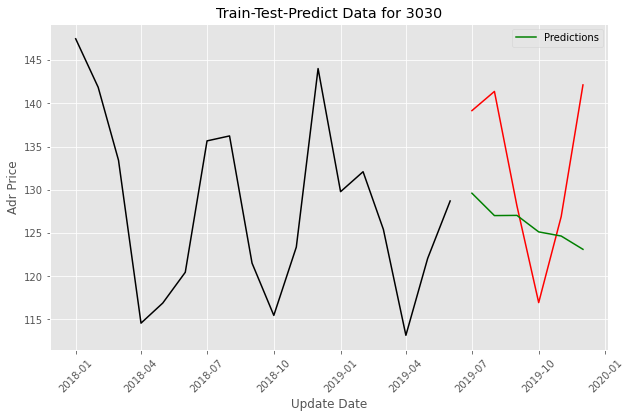

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21505D+00    |proj g|=  7.71183D-01

At iterate    5    f=  4.52096D+00    |proj g|=  9.06820D-02

At iterate   10    f=  4.21244D+00    |proj g|=  4.54275D-03

At iterate   15    f=  4.21059D+00    |proj g|=  7.96534D-04

At iterate   20    f=  4.20952D+00    |proj g|=  1.82751D-02

At iterate   25    f=  4.20810D+00    |proj g|=  1.25400D-04

At iterate   30    f=  4.20810D+00    |proj g|=  4.93800D-04

At iterate   35    f=  4.20805D+00    |proj g|=  2.25196D-03

At iterate   40    f=  4.20804D+00    |proj g|=  7.50515D-04

At iterate   45    f=  4.20802D+00    |proj g|=  1.05737D-03

At iterate   50    f=  4.20802D+00    |proj g|=  1.00186D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


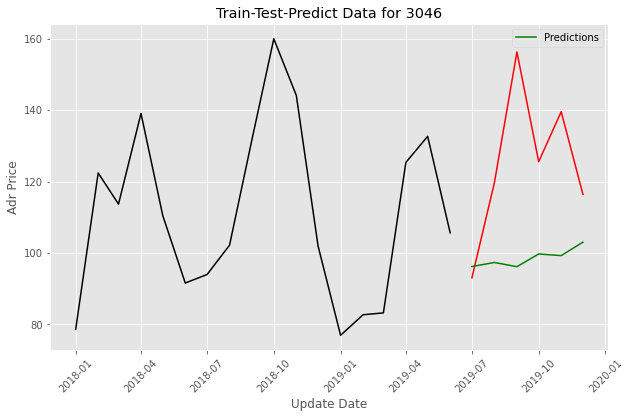

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04045D+00    |proj g|=  2.02708D-01

At iterate    5    f=  3.00290D+00    |proj g|=  1.44038D-02

At iterate   10    f=  2.99488D+00    |proj g|=  3.66460D-03

At iterate   15    f=  2.99401D+00    |proj g|=  6.30737D-03

At iterate   20    f=  2.99390D+00    |proj g|=  1.94494D-03

At iterate   25    f=  2.99389D+00    |proj g|=  2.53653D-04

At iterate   30    f=  2.99389D+00    |proj g|=  9.11641D-05

At iterate   35    f=  2.99389D+00    |proj g|=  5.68807D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


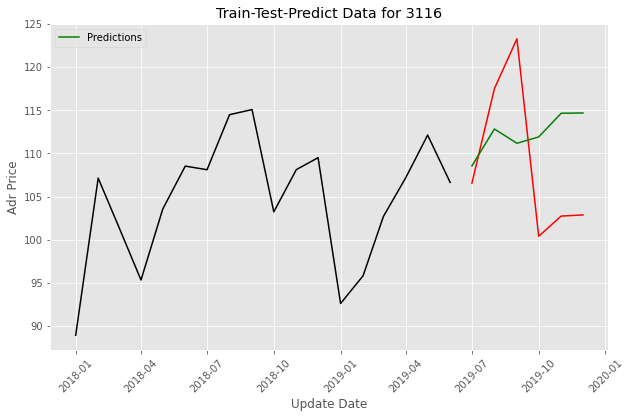

In [8]:
# building seperate models for each county and storing the rmse values
rmse_error = {}
for county in seas_df_pd["county_id"].unique():
    seas_df_pd_county = seas_df_pd[seas_df_pd["county_id"] == county]
    train = seas_df_pd_county[seas_df_pd_county.index < pd.to_datetime("2019-07-01", format='%Y-%m-%d')]
    test = seas_df_pd_county[seas_df_pd_county.index >= pd.to_datetime("2019-07-01", format='%Y-%m-%d')][["adr"]]
    y = train['adr']
    ARMAmodel0 = SARIMAX(y, order = (2, 2, 2))
    ARMAmodel0 = ARMAmodel0.fit()
    y_pred = ARMAmodel0.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.5)
    y_pred_df["Predictions"] = ARMAmodel0.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"] 
    print("The root mean square error for the" + str(county) + " is " + str(math.sqrt(((y_pred_out - test.iloc[:,0]) ** 2).mean())))
    
    print(pd.concat([test.iloc[:,0], y_pred_out], axis=1))
    
    rmse_error.update({county: math.sqrt(((y_pred_out - test.iloc[:,0]) ** 2).mean())})
    
    

    plt.plot(train[["adr"]], color = "black")
    plt.plot(test[["adr"]], color = "red")
    plt.plot(y_pred_out, color='green', label = 'Predictions')
    plt.ylabel('Adr Price')
    plt.xlabel('Update Date')
    plt.xticks(rotation=45)
    plt.title("Train-Test-Predict Data for " + str(county))
    plt.legend()
    plt.show()





In [9]:
# county if with RMSE greater than 20 
[(i, value) for i, value in rmse_error.items() if value > 20]

[(469, 98.37215843325023),
 (517, 30.78265633496964),
 (608, 126.5162001027664),
 (651, 45.78045852475333),
 (808, 33.41396026044668),
 (1081, 307.05345951540244),
 (1400, 42.48088503089377),
 (1501, 81.00295522534162),
 (1517, 74.07343304940335),
 (1660, 32.424212160399364),
 (1827, 29.495661942382977),
 (2181, 25.301449700926703),
 (2212, 33.39941629827333),
 (2530, 50.370939969588306),
 (2669, 32.99076013944326),
 (2909, 24.222939969565576),
 (2916, 33.67439245568603),
 (3046, 33.16056976218201)]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30502D+00    |proj g|=  3.68469D-02

At iterate    5    f=  4.29432D+00    |proj g|=  1.09300D-01

At iterate   10    f=  4.27188D+00    |proj g|=  9.55412D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   7.959D-06   4.272D+00
  F =   4.2718176875481140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the469 is 28.75667645554548
           

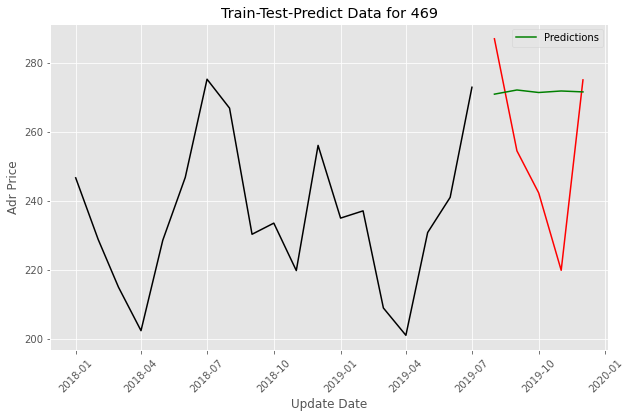

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13521D+00    |proj g|=  4.35214D-02

At iterate    5    f=  3.13139D+00    |proj g|=  1.22757D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.381D-06   3.131D+00
  F =   3.1311171824297848     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the517 is 28.16837957604033
                   adr  Predictions
date                               
2

 This problem is unconstrained.


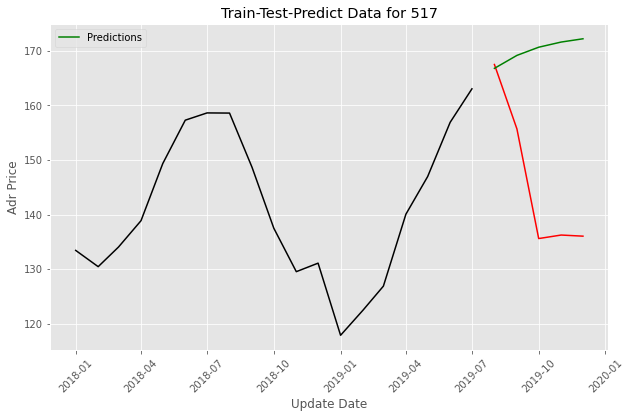

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08332D+01    |proj g|=  6.53319D+00

At iterate    5    f=  6.21379D+00    |proj g|=  1.94965D-01

At iterate   10    f=  5.76124D+00    |proj g|=  8.37029D-02

At iterate   15    f=  5.64345D+00    |proj g|=  6.86198D-03

At iterate   20    f=  5.62404D+00    |proj g|=  3.25579D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     32      1     0     0   1.838D-06   5.620D+00
  F =   5.6196611633618518     

CONVERG

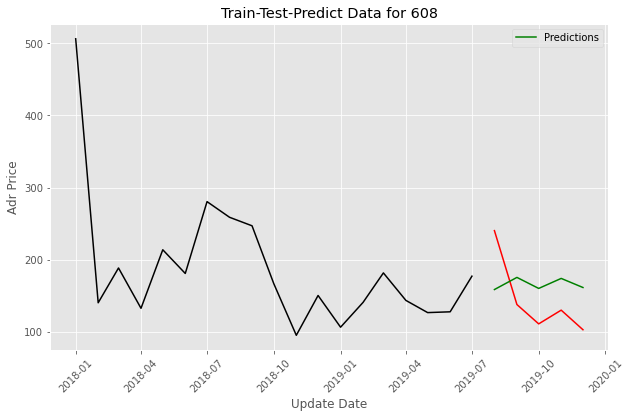

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86349D+00    |proj g|=  4.42247D-01

At iterate    5    f=  3.70275D+00    |proj g|=  6.52870D-02

At iterate   10    f=  3.68166D+00    |proj g|=  3.52933D-02

At iterate   15    f=  3.67215D+00    |proj g|=  2.15727D-03

At iterate   20    f=  3.67160D+00    |proj g|=  7.93393D-05

At iterate   25    f=  3.67155D+00    |proj g|=  3.18741D-05

At iterate   30    f=  3.67155D+00    |proj g|=  8.99468D-05

At iterate   35    f=  3.67155D+00    |proj g|=  4.34935D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

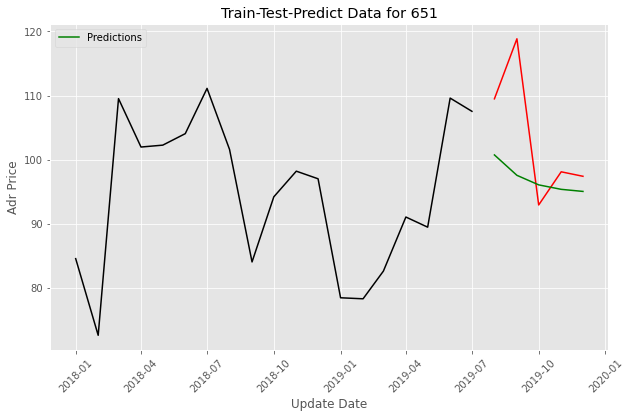

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.29909D+00    |proj g|=  9.51006D-02

At iterate    5    f=  4.24002D+00    |proj g|=  9.93521D-03

At iterate   10    f=  4.22611D+00    |proj g|=  2.66570D-04

At iterate   15    f=  4.22596D+00    |proj g|=  1.48926D-03

At iterate   20    f=  4.22588D+00    |proj g|=  2.04609D-04

At iterate   25    f=  4.22587D+00    |proj g|=  3.00095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     32      1     0     0   

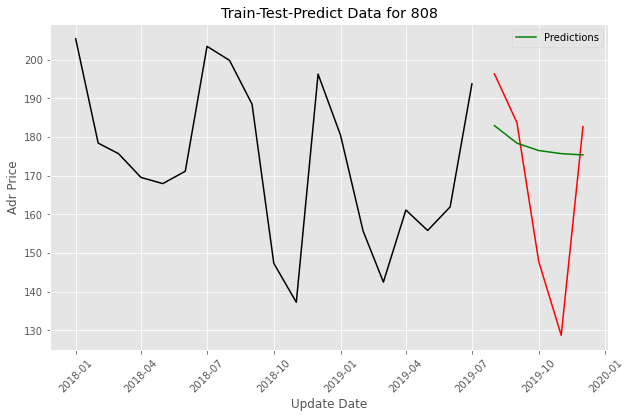

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90435D+00    |proj g|=  3.29435D-02

At iterate    5    f=  4.90332D+00    |proj g|=  1.68369D-02

At iterate   10    f=  4.90260D+00    |proj g|=  9.16479D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   9.799D-06   4.903D+00
  F =   4.9025965587304841     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the1081 is 64.81744387342356
          

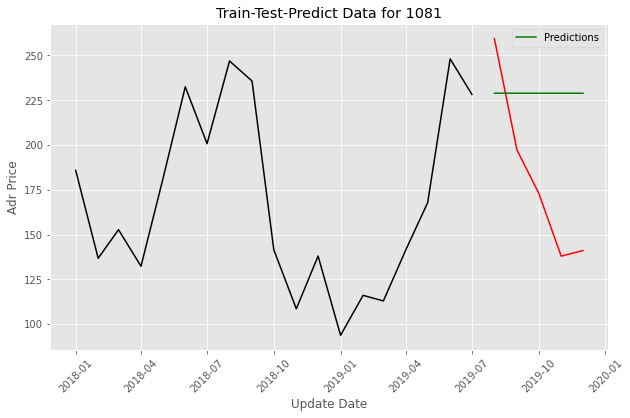

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08553D+00    |proj g|=  1.12849D-01

At iterate    5    f=  3.07874D+00    |proj g|=  1.27041D-02

At iterate   10    f=  3.07798D+00    |proj g|=  1.57860D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   2.925D-06   3.078D+00
  F =   3.0779785354630995     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the1400 is 16.23469217091575
          

 This problem is unconstrained.


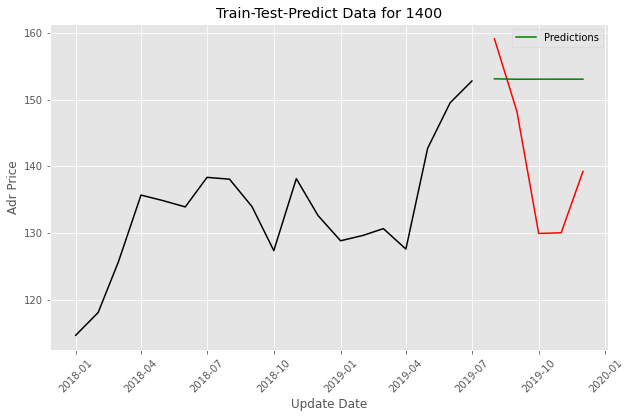

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38070D+00    |proj g|=  2.93308D-02


 This problem is unconstrained.



At iterate    5    f=  3.37855D+00    |proj g|=  8.82923D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   3.102D-06   3.378D+00
  F =   3.3780957895468036     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the1501 is 23.054400999308356
                   adr  Predictions
date                               
2019-08-01  154.191373   149.595103
2019-09-01  140.063086   149.400210
2019-10-01  124.422097   149.356344
2019-11-01  118.429562   149.346471
2019-12-01  118.172987   149.344248


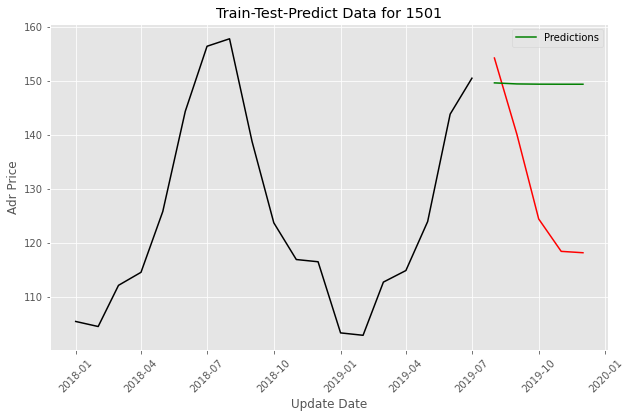

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61043D+00    |proj g|=  1.24154D-01

At iterate    5    f=  4.55761D+00    |proj g|=  1.08849D-01

At iterate   10    f=  4.50988D+00    |proj g|=  7.81681D-03

At iterate   15    f=  4.49784D+00    |proj g|=  3.44109D-04

At iterate   20    f=  4.49782D+00    |proj g|=  2.43798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     30      1     0     0   8.712D-06   4.498D+00
  F =   4.4978095863771843     

CONVERG

 This problem is unconstrained.


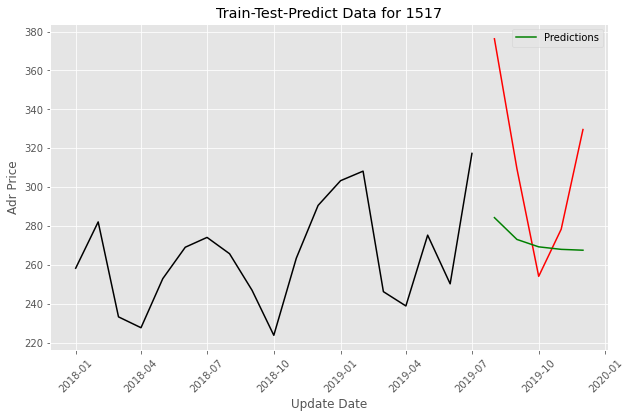

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32803D+00    |proj g|=  1.85556D-01

At iterate    5    f=  4.29988D+00    |proj g|=  8.98499D-02

At iterate   10    f=  4.28041D+00    |proj g|=  1.84448D-02

At iterate   15    f=  4.27559D+00    |proj g|=  5.08091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   2.292D-06   4.276D+00
  F =   4.2755711730488715     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root

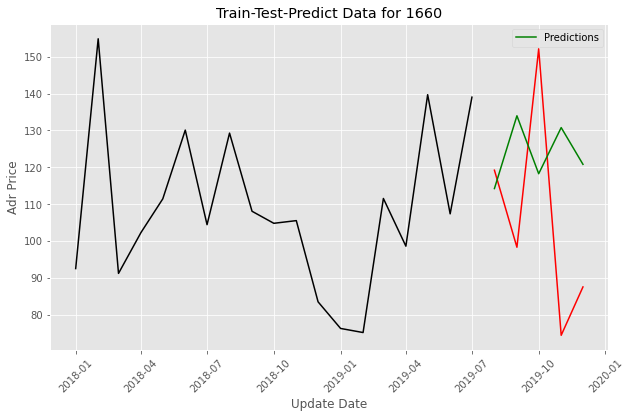

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75941D+00    |proj g|=  5.46355D-02

At iterate    5    f=  3.70765D+00    |proj g|=  1.20452D-02

At iterate   10    f=  3.70243D+00    |proj g|=  1.77199D-03

At iterate   15    f=  3.70175D+00    |proj g|=  2.86033D-04

At iterate   20    f=  3.70169D+00    |proj g|=  2.08018D-04

At iterate   25    f=  3.70169D+00    |proj g|=  1.58265D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     39      1     0     0   

 This problem is unconstrained.


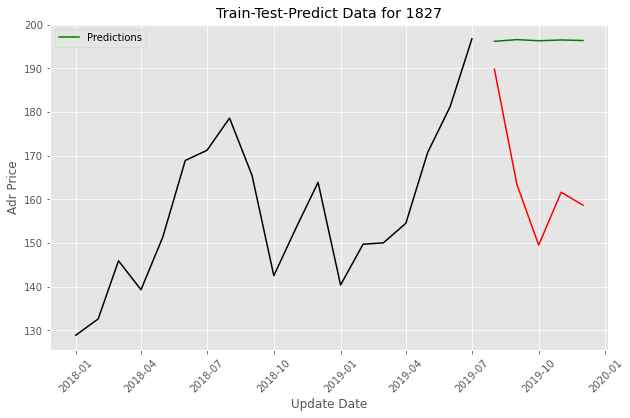

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70865D+00    |proj g|=  1.49354D-02

At iterate    5    f=  3.67489D+00    |proj g|=  1.72586D-02

At iterate   10    f=  3.66916D+00    |proj g|=  5.55257D-04

At iterate   15    f=  3.66914D+00    |proj g|=  8.02603D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   6.317D-07   3.669D+00
  F =   3.6691358199725550     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root

 This problem is unconstrained.


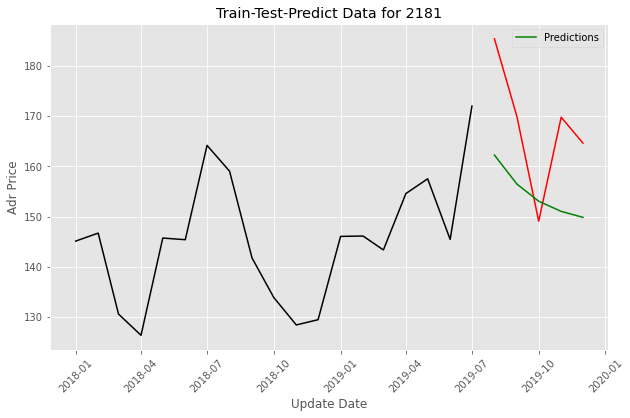

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.80140D+00    |proj g|=  3.67610D-01

At iterate    5    f=  4.74870D+00    |proj g|=  1.48810D-01

At iterate   10    f=  4.68464D+00    |proj g|=  1.25734D-02

At iterate   15    f=  4.68436D+00    |proj g|=  3.42011D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   3.420D-06   4.684D+00
  F =   4.6843586570660030     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root

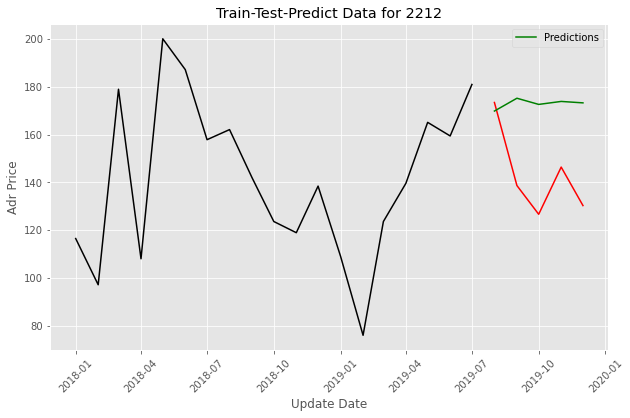

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.67940D+00    |proj g|=  1.68797D-02

At iterate    5    f=  3.67662D+00    |proj g|=  3.44191D-02

At iterate   10    f=  3.67503D+00    |proj g|=  9.11518D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   4.111D-07   3.675D+00
  F =   3.6750329874734113     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the2530 is 53.40493822096769
          

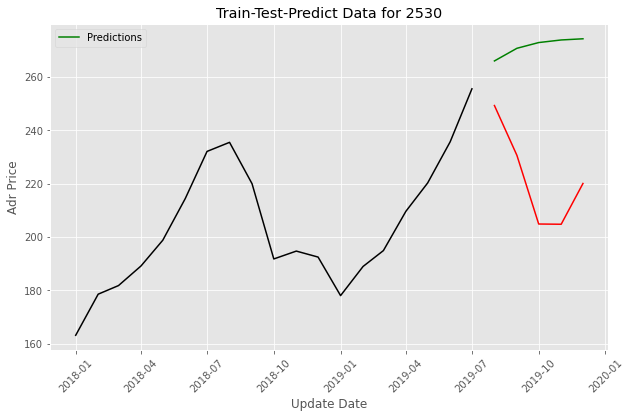

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14402D+00    |proj g|=  4.63385D-02

At iterate    5    f=  3.14038D+00    |proj g|=  8.47886D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   8.670D-06   3.140D+00
  F =   3.1403829402142671     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the2669 is 11.694248276220405
                   adr  Predictions
date                               

 This problem is unconstrained.


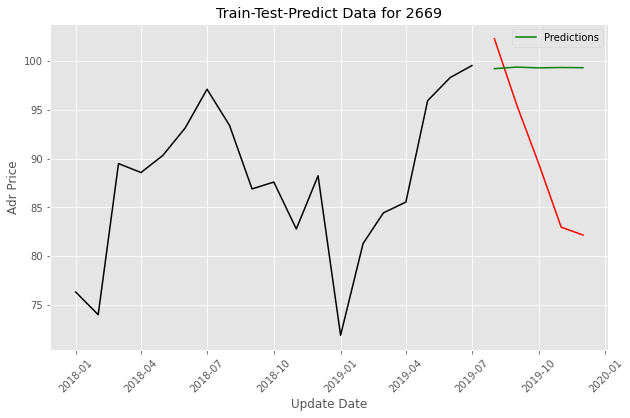

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55724D+00    |proj g|=  7.98079D-02

At iterate    5    f=  3.55250D+00    |proj g|=  1.18293D-02

At iterate   10    f=  3.55229D+00    |proj g|=  5.64508D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   9.295D-07   3.552D+00
  F =   3.5522623580819515     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the2909 is 12.384199820736635
         

 This problem is unconstrained.


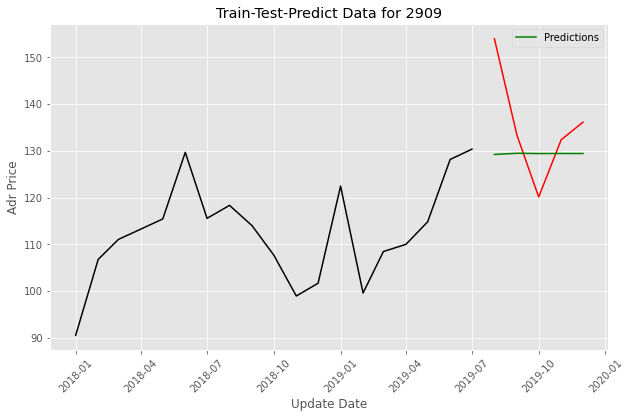

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01731D+00    |proj g|=  1.22052D-01

At iterate    5    f=  4.00528D+00    |proj g|=  1.15352D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   5.934D-06   4.005D+00
  F =   4.0046656062325585     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the2916 is 26.264798729532043
                   adr  Predictions
date                               

 This problem is unconstrained.


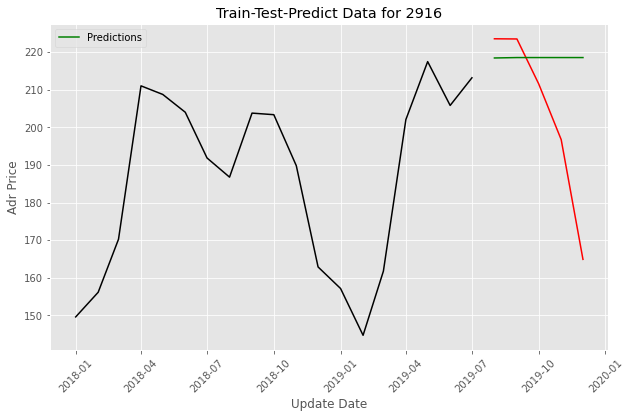

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39288D+00    |proj g|=  9.45348D-02

At iterate    5    f=  4.37366D+00    |proj g|=  1.05163D-02

At iterate   10    f=  4.36655D+00    |proj g|=  4.05047D-02

At iterate   15    f=  4.36173D+00    |proj g|=  5.66756D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   5.668D-06   4.362D+00
  F =   4.3617277580158031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root

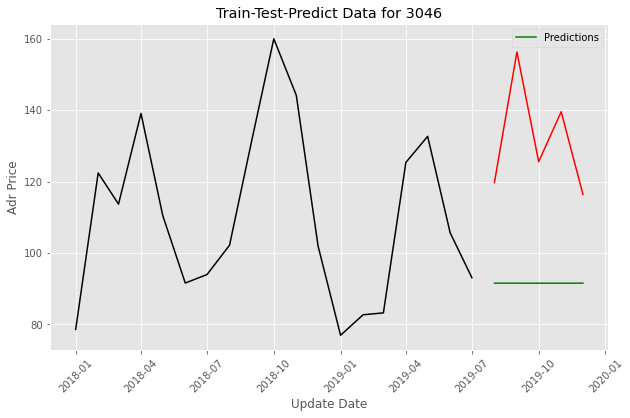

In [10]:
# building seperate models for the county with rmse > 20 from the previous models here are using differnt parametere to fine tune the model
rmse_error1 = {}
for county in [i for i, value in rmse_error.items() if value > 20]:
    seas_df_pd_county = seas_df_pd[seas_df_pd["county_id"] == county]
    train = seas_df_pd_county[seas_df_pd_county.index < pd.to_datetime("2019-08-01", format='%Y-%m-%d')]
    test = seas_df_pd_county[seas_df_pd_county.index >= pd.to_datetime("2019-08-01", format='%Y-%m-%d')][["adr"]]
    y = train['adr']
    ARMAmodel1 = SARIMAX(y, order = (1, 1, 1))
    ARMAmodel1 = ARMAmodel1.fit()
    y_pred = ARMAmodel1.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.5)
    y_pred_df["Predictions"] = ARMAmodel1.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"] 
    print("The root mean square error for the" + str(county) + " is " + str(math.sqrt(((y_pred_out - test.iloc[:,0]) ** 2).mean())))
    print(pd.concat([test.iloc[:,0], y_pred_out], axis=1))
    
    rmse_error1.update({county: math.sqrt(((y_pred_out - test.iloc[:,0]) ** 2).mean())})
    
    

    plt.plot(train[["adr"]], color = "black")
    plt.plot(test[["adr"]], color = "red")
    plt.plot(y_pred_out, color='green', label = 'Predictions')
    plt.ylabel('Adr Price')
    plt.xlabel('Update Date')
    plt.xticks(rotation=45)
    plt.title("Train-Test-Predict Data for " + str(county))
    plt.legend()
    plt.show()






RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34203D+00    |proj g|=  3.62535D-01

At iterate    5    f=  3.25254D+00    |proj g|=  2.19452D-02

At iterate   10    f=  3.24949D+00    |proj g|=  1.87737D-03

At iterate   15    f=  3.24948D+00    |proj g|=  1.65636D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   7.047D-05   3.249D+00
  F =   3.2494791900495494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The root

 This problem is unconstrained.


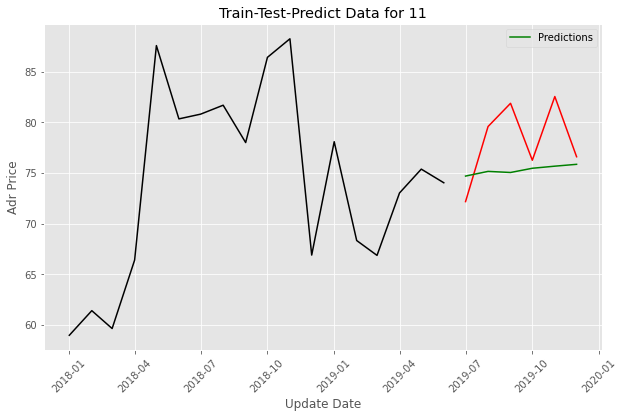

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33493D+00    |proj g|=  4.01638D-01

At iterate    5    f=  3.07194D+00    |proj g|=  1.48249D-02

At iterate   10    f=  3.06926D+00    |proj g|=  2.18915D-03

At iterate   15    f=  3.06860D+00    |proj g|=  1.51269D-03

At iterate   20    f=  3.06848D+00    |proj g|=  6.82497D-04

At iterate   25    f=  3.06847D+00    |proj g|=  1.30312D-04

At iterate   30    f=  3.06847D+00    |proj g|=  2.18205D-05

At iterate   35    f=  3.06847D+00    |proj g|=  4.02581D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

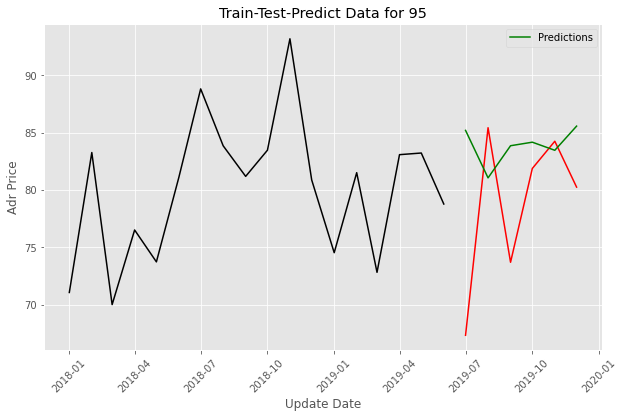

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16443D+00    |proj g|=  1.29020D-01

At iterate    5    f=  3.13188D+00    |proj g|=  8.76169D-02

At iterate   10    f=  3.12236D+00    |proj g|=  1.95730D-02

At iterate   15    f=  3.10180D+00    |proj g|=  4.20470D-02

At iterate   20    f=  3.09047D+00    |proj g|=  9.30674D-03

At iterate   25    f=  3.08914D+00    |proj g|=  2.39850D-03

At iterate   30    f=  3.08901D+00    |proj g|=  6.60786D-04

At iterate   35    f=  3.08899D+00    |proj g|=  3.69776D-04

At iterate   40    f=  3.08899D+00    |proj g|=  2.64396D-04

At iterate   45    f=  3.08899D+00    |proj g|=  1.96878D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


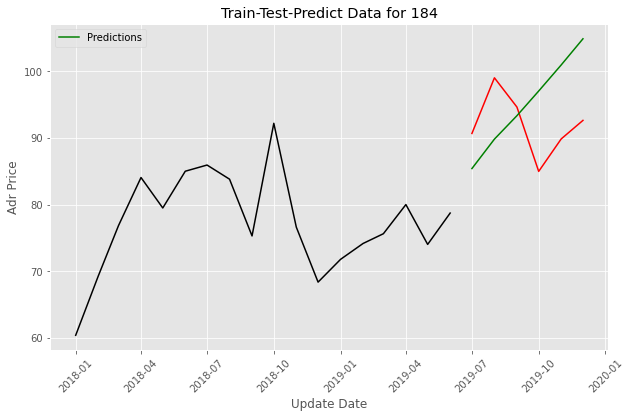

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32181D+00    |proj g|=  7.84225D-01

At iterate    5    f=  4.12882D+00    |proj g|=  1.39888D-01

At iterate   10    f=  4.05586D+00    |proj g|=  4.16103D-02

At iterate   15    f=  4.04338D+00    |proj g|=  4.21177D-02

At iterate   20    f=  4.02014D+00    |proj g|=  1.77730D-02

At iterate   25    f=  4.01012D+00    |proj g|=  1.99573D-02

At iterate   30    f=  4.00997D+00    |proj g|=  4.56821D-03

At iterate   35    f=  4.00943D+00    |proj g|=  4.18425D-03

At iterate   40    f=  4.00928D+00    |proj g|=  6.56229D-04

At iterate   45    f=  4.00925D+00    |proj g|=  8.90118D-05

At iterate   50    f=  4.00925D+00    |proj g|=  2.55180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


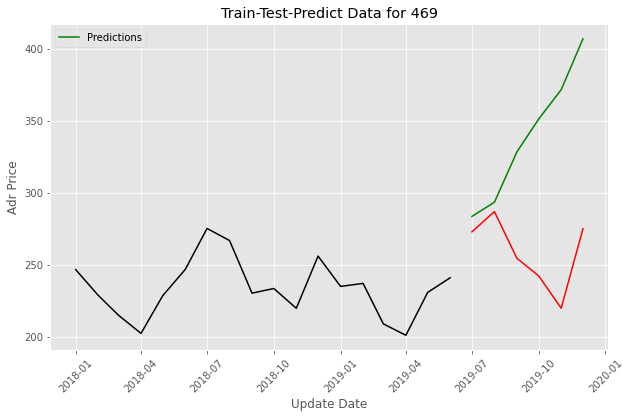

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09738D+00    |proj g|=  4.01883D-01

At iterate    5    f=  2.99944D+00    |proj g|=  8.64793D-02

At iterate   10    f=  2.96240D+00    |proj g|=  2.69175D-02

At iterate   15    f=  2.95570D+00    |proj g|=  5.24145D-03

At iterate   20    f=  2.95496D+00    |proj g|=  4.93853D-04

At iterate   25    f=  2.95486D+00    |proj g|=  9.91671D-04

At iterate   30    f=  2.95485D+00    |proj g|=  2.00963D-04

At iterate   35    f=  2.95485D+00    |proj g|=  1.06698D-04

At iterate   40    f=  2.95485D+00    |proj g|=  9.56475D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

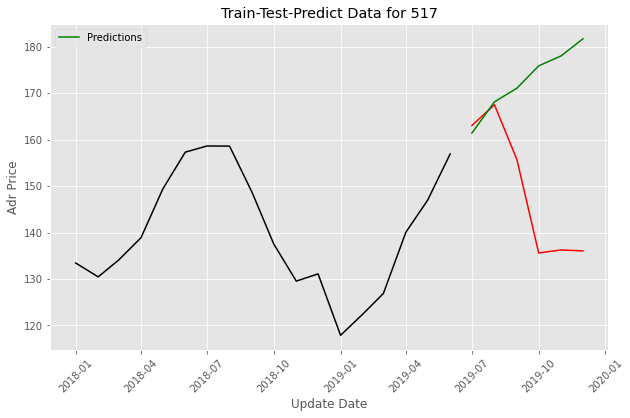

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65628D+00    |proj g|=  2.70248D-01

At iterate    5    f=  2.59809D+00    |proj g|=  8.35234D-02

At iterate   10    f=  2.59184D+00    |proj g|=  3.51574D-03

At iterate   15    f=  2.59170D+00    |proj g|=  7.57116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   8.971D-06   2.592D+00
  F =   2.5916986030290818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root

 This problem is unconstrained.


KeyboardInterrupt: 

In [76]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

date_today = datetime.now()
days = pd.date_range(date_today, date_today + timedelta(7), freq='D')

In [77]:

days

DatetimeIndex(['2022-07-22 14:09:02.096904', '2022-07-23 14:09:02.096904',
               '2022-07-24 14:09:02.096904', '2022-07-25 14:09:02.096904',
               '2022-07-26 14:09:02.096904', '2022-07-27 14:09:02.096904',
               '2022-07-28 14:09:02.096904', '2022-07-29 14:09:02.096904'],
              dtype='datetime64[ns]', freq='D')

In [26]:
# reading the listing data to get the months for which we want to have the projections along with the new data for which we want to make the projections on
ld_df = spark.read.csv("/Users/prapul/Documents/Exported Tables/listings.csv", header = True, inferSchema = True, escape = "\"")
ld_df = ld_df.withColumn("updated_at", F.date_format('updated_at', "yyyy-MM-dd").cast(DateType())).sort(F.col("updated_at"))
ld_df = ld_df.toPandas()[["updated_at", "county_id"]].set_index("updated_at")

In [27]:
# ld_df.select("updated_at").show()

ld_df.index[0]

datetime.date(2021, 3, 28)

In [28]:
# function to get predictions based on the date and the zipcode of the listings:
ld_df

county_id
updated_at           
2021-03-28     1501.0
2021-03-28     1501.0
2021-03-28     2652.0
2021-03-28     1501.0
2021-03-28     1501.0
...               ...
2022-06-09     2652.0
2022-06-09     1501.0
2022-06-09     1501.0
2022-06-09     1642.0
2022-06-09      517.0

[35447 rows x 1 columns]

In [171]:
pd.DataFrame(ARMAmodel0.predict(start = ld_df.index[0]- datetime.timedelta(days=30), end = ld_df.index[-1]))
# import datetime
# today = datetime.date.today()
# first = today.replace(day=1)
# lastMonth = first - datetime.timedelta(days=1)
# print(lastMonth.strftime("%Y%m"))


predicted_mean
2021-09-01      135.670404
2021-10-01      136.662947
2021-11-01      137.657064
2021-12-01      138.655702
2022-01-01      139.650508
2022-02-01      140.645066
2022-03-01      141.642071
2022-04-01      142.637659
2022-05-01      143.632692
2022-06-01      144.628926
2022-07-01      145.624723

In [29]:
# using different model for the models which have more rmse even in the model 2 as well
model_2_county_id = [i for i, value in rmse_error.items() if value > 20]
model_3_county_id = [1501, 2916, 1081, 1517]


Using model 2 for 1501.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38070D+00    |proj g|=  2.93308D-02

At iterate    5    f=  3.37855D+00    |proj g|=  8.82923D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   3.102D-06   3.378D+00
  F =   3.3780957895468036     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the3046 is 23.054400999308356
                   adr  Predictions
date      

 This problem is unconstrained.


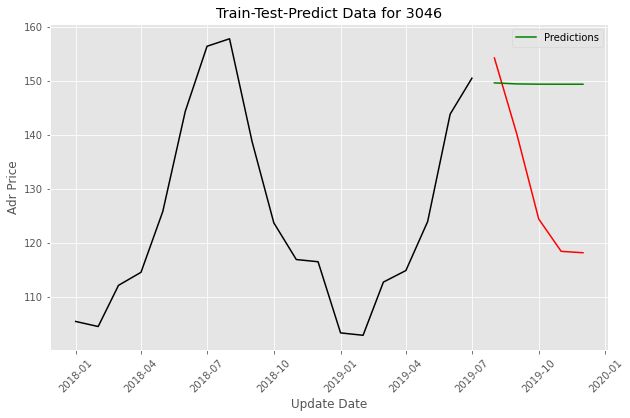

            predicted_mean county_id
2021-03-01      149.343603      1501
2021-04-01      149.343603      1501
2021-05-01      149.343603      1501
2021-06-01      149.343603      1501
2021-07-01      149.343603      1501
2021-08-01      149.343603      1501
2021-09-01      149.343603      1501
2021-10-01      149.343603      1501
2021-11-01      149.343603      1501
2021-12-01      149.343603      1501
2022-01-01      149.343603      1501
2022-02-01      149.343603      1501
2022-03-01      149.343603      1501
2022-04-01      149.343603      1501
2022-05-01      149.343603      1501
2022-06-01      149.343603      1501
2022-07-01      149.343603      1501
Using model 1 for 2652.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86598D+00    |proj g|=  2.94678D-01

At iterate    5    f=  2.78602D+00    |proj g|=  3.87463D-02

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.


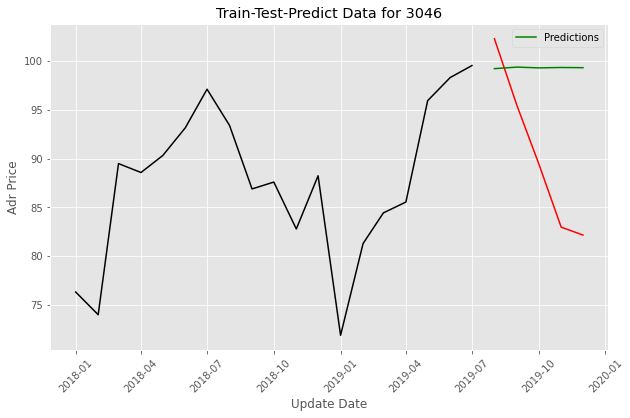

            predicted_mean county_id
2021-03-01       99.336207      2669
2021-04-01       99.336207      2669
2021-05-01       99.336207      2669
2021-06-01       99.336207      2669
2021-07-01       99.336207      2669
2021-08-01       99.336207      2669
2021-09-01       99.336207      2669
2021-10-01       99.336207      2669
2021-11-01       99.336207      2669
2021-12-01       99.336207      2669
2022-01-01       99.336207      2669
2022-02-01       99.336207      2669
2022-03-01       99.336207      2669
2022-04-01       99.336207      2669
2022-05-01       99.336207      2669
2022-06-01       99.336207      2669
2022-07-01       99.336207      2669
Using model 1 for 3030.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84292D+00    |proj g|=  5.97045D-01

At iterate    5    f=  3.46710D+00    |proj g|=  3.25154D-02

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.


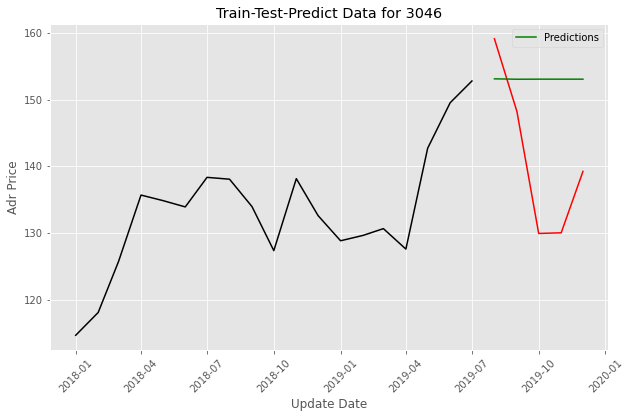

            predicted_mean county_id
2021-03-01      153.054025      1400
2021-04-01      153.054025      1400
2021-05-01      153.054025      1400
2021-06-01      153.054025      1400
2021-07-01      153.054025      1400
2021-08-01      153.054025      1400
2021-09-01      153.054025      1400
2021-10-01      153.054025      1400
2021-11-01      153.054025      1400
2021-12-01      153.054025      1400
2022-01-01      153.054025      1400
2022-02-01      153.054025      1400
2022-03-01      153.054025      1400
2022-04-01      153.054025      1400
2022-05-01      153.054025      1400
2022-06-01      153.054025      1400
2022-07-01      153.054025      1400
Using model 2 for 651.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86349D+00    |proj g|=  4.42247D-01

At iterate    5    f=  3.70275D+00    |proj g|=  6.52870D-02

At iterate   10   

 This problem is unconstrained.


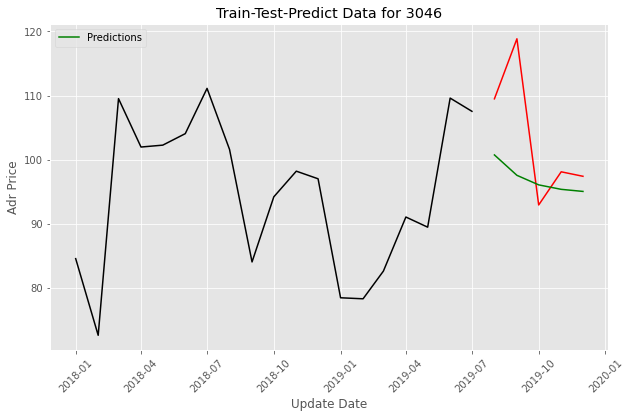

            predicted_mean county_id
2021-03-01       94.748055       651
2021-04-01       94.748054       651
2021-05-01       94.748053       651
2021-06-01       94.748052       651
2021-07-01       94.748052       651
2021-08-01       94.748052       651
2021-09-01       94.748052       651
2021-10-01       94.748052       651
2021-11-01       94.748052       651
2021-12-01       94.748052       651
2022-01-01       94.748052       651
2022-02-01       94.748052       651
2022-03-01       94.748052       651
2022-04-01       94.748052       651
2022-05-01       94.748052       651
2022-06-01       94.748052       651
2022-07-01       94.748052       651
Using model 2 for 517.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13521D+00    |proj g|=  4.35214D-02

At iterate    5    f=  3.13139D+00    |proj g|=  1.22757D-02

           * * *



 This problem is unconstrained.


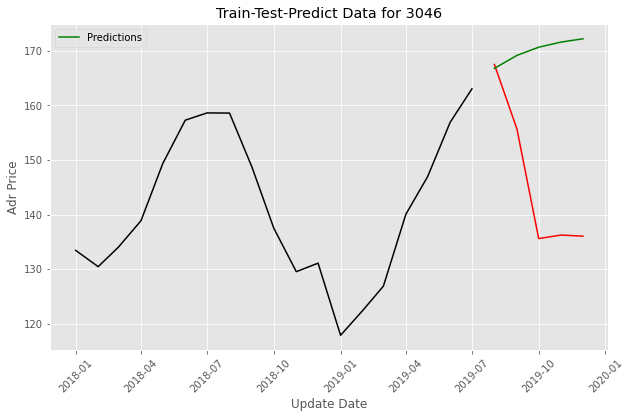

            predicted_mean county_id
2021-03-01      173.226347       517
2021-04-01      173.226733       517
2021-05-01      173.226976       517
2021-06-01      173.227130       517
2021-07-01      173.227227       517
2021-08-01      173.227289       517
2021-09-01      173.227328       517
2021-10-01      173.227352       517
2021-11-01      173.227368       517
2021-12-01      173.227377       517
2022-01-01      173.227383       517
2022-02-01      173.227387       517
2022-03-01      173.227390       517
2022-04-01      173.227391       517
2022-05-01      173.227392       517
2022-06-01      173.227393       517
2022-07-01      173.227393       517


 This problem is unconstrained.


Using model 1 for 2254.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17669D+00    |proj g|=  1.26034D-01

At iterate    5    f=  3.15150D+00    |proj g|=  3.05912D-03

At iterate   10    f=  3.14608D+00    |proj g|=  3.60530D-03

At iterate   15    f=  3.14433D+00    |proj g|=  3.32079D-03

At iterate   20    f=  3.14397D+00    |proj g|=  6.65405D-04

At iterate   25    f=  3.14395D+00    |proj g|=  3.36940D-05

At iterate   30    f=  3.14394D+00    |proj g|=  2.28252D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit 

 This problem is unconstrained.


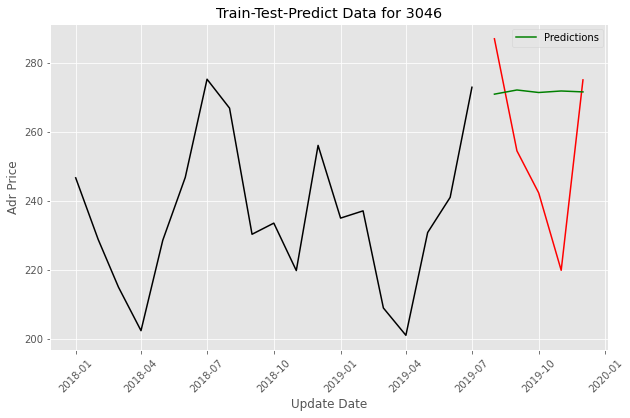

            predicted_mean county_id
2021-03-01      271.761516       469
2021-04-01      271.761434       469
2021-05-01      271.761483       469
2021-06-01      271.761453       469
2021-07-01      271.761471       469
2021-08-01      271.761460       469
2021-09-01      271.761467       469
2021-10-01      271.761463       469
2021-11-01      271.761466       469
2021-12-01      271.761464       469
2022-01-01      271.761465       469
2022-02-01      271.761464       469
2022-03-01      271.761465       469
2022-04-01      271.761465       469
2022-05-01      271.761465       469
2022-06-01      271.761465       469
2022-07-01      271.761465       469
Using model 2 for 1517.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61043D+00    |proj g|=  1.24154D-01

At iterate    5    f=  4.55761D+00    |proj g|=  1.08849D-01

At iterate   10  

 This problem is unconstrained.


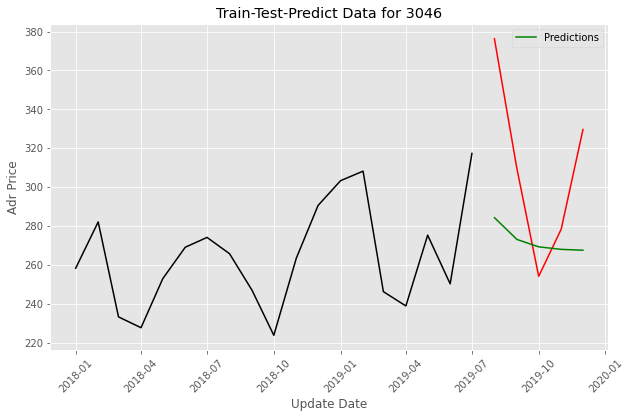

            predicted_mean county_id
2021-03-01      267.296300      1517
2021-04-01      267.296300      1517
2021-05-01      267.296299      1517
2021-06-01      267.296299      1517
2021-07-01      267.296299      1517
2021-08-01      267.296299      1517
2021-09-01      267.296299      1517
2021-10-01      267.296299      1517
2021-11-01      267.296299      1517
2021-12-01      267.296299      1517
2022-01-01      267.296299      1517
2022-02-01      267.296299      1517
2022-03-01      267.296299      1517
2022-04-01      267.296299      1517
2022-05-01      267.296299      1517
2022-06-01      267.296299      1517
2022-07-01      267.296299      1517
Using model 1 for 1516.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51246D+00    |proj g|=  7.17051D-01

At iterate    5    f=  3.23408D+00    |proj g|=  4.41332D-02

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   8.971D-06   2.592D+00
  F =   2.5916986030290818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
            predicted_mean county_id
2021-03-01      203.234584       521
2021-04-01      208.685323       521
2021-05-01      214.112858       521
2021-06-01      219.433131       521
2021-07-01      224.798242       521
2021-08-01      230.231064       521
2021-09-01      235.613266       521
2021-10-01      240.958484       521
2021-11-01      246.350665       521
2021-12-01      251.758061       521
2022-01-01      

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  3.49247D+00    |proj g|=  4.41468D-04

At iterate   40    f=  3.49244D+00    |proj g|=  3.02276D-05

At iterate   45    f=  3.49243D+00    |proj g|=  2.35838D-04

At iterate   50    f=  3.49243D+00    |proj g|=  2.76854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   2.769D-04   3.492D+00
  F =   3.4924286059728535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
            predicted_mean county_id
2021-03-01      180.257488      1521
2021-04-01      183.613274      1521
2021-05-01      182.482256      1521
2021-06-01      185.836944 

 This problem is unconstrained.


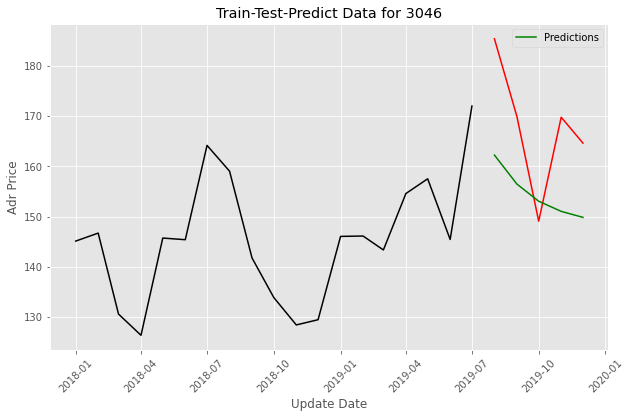

            predicted_mean county_id
2021-03-01      148.133715      2181
2021-04-01      148.133447      2181
2021-05-01      148.133289      2181
2021-06-01      148.133195      2181
2021-07-01      148.133139      2181
2021-08-01      148.133106      2181
2021-09-01      148.133087      2181
2021-10-01      148.133076      2181
2021-11-01      148.133069      2181
2021-12-01      148.133065      2181
2022-01-01      148.133062      2181
2022-02-01      148.133061      2181
2022-03-01      148.133060      2181
2022-04-01      148.133060      2181
2022-05-01      148.133059      2181
2022-06-01      148.133059      2181
2022-07-01      148.133059      2181
Using model 1 for 2789.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95331D+00    |proj g|=  2.26220D-01

At iterate    5    f=  2.89288D+00    |proj g|=  3.01062D-02

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.


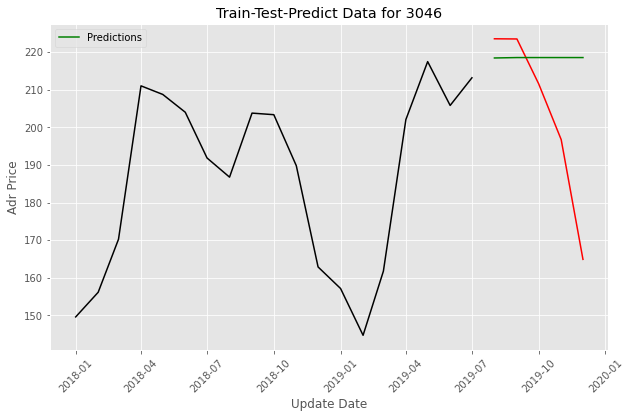

            predicted_mean county_id
2021-03-01      218.523634      2916
2021-04-01      218.523634      2916
2021-05-01      218.523634      2916
2021-06-01      218.523634      2916
2021-07-01      218.523634      2916
2021-08-01      218.523634      2916
2021-09-01      218.523634      2916
2021-10-01      218.523634      2916
2021-11-01      218.523634      2916
2021-12-01      218.523634      2916
2022-01-01      218.523634      2916
2022-02-01      218.523634      2916
2022-03-01      218.523634      2916
2022-04-01      218.523634      2916
2022-05-01      218.523634      2916
2022-06-01      218.523634      2916
2022-07-01      218.523634      2916
Using model 2 for 1827.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75941D+00    |proj g|=  5.46355D-02

At iterate    5    f=  3.70765D+00    |proj g|=  1.20452D-02

At iterate   10  

 This problem is unconstrained.


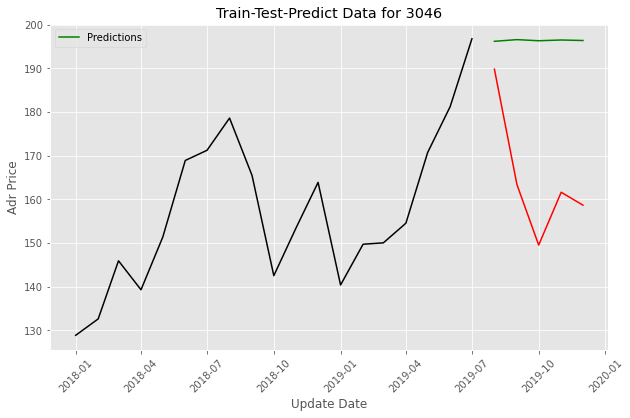

            predicted_mean county_id
2021-03-01      196.404038      1827
2021-04-01      196.403850      1827
2021-05-01      196.403976      1827
2021-06-01      196.403891      1827
2021-07-01      196.403948      1827
2021-08-01      196.403910      1827
2021-09-01      196.403935      1827
2021-10-01      196.403918      1827
2021-11-01      196.403930      1827
2021-12-01      196.403922      1827
2022-01-01      196.403927      1827
2022-02-01      196.403924      1827
2022-03-01      196.403926      1827
2022-04-01      196.403925      1827
2022-05-01      196.403926      1827
2022-06-01      196.403925      1827
2022-07-01      196.403925      1827
Using model 1 for 1355.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19681D+00    |proj g|=  9.68831D-02

At iterate    5    f=  3.13848D+00    |proj g|=  1.37909D-02

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   35    f=  3.16644D+00    |proj g|=  1.12156D-04

At iterate   40    f=  3.16644D+00    |proj g|=  1.71167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     48      1     0     0   1.712D-04   3.166D+00
  F =   3.1664425947068731     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
            predicted_mean county_id
2021-03-01       74.203526       958
2021-04-01       74.663844       958
2021-05-01       75.114268       958
2021-06-01       75.580084       958
2021-07-01       76.039826       958
2021-08-01       76.495506       958
2021-09-01       76.957672       958
202

 This problem is unconstrained.


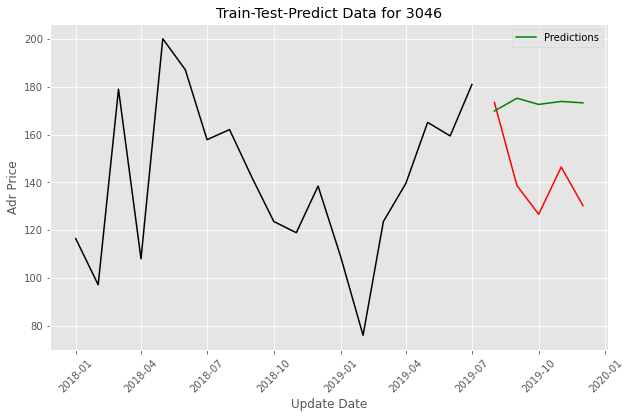

 This problem is unconstrained.


            predicted_mean county_id
2021-03-01      173.500854      2212
2021-04-01      173.500848      2212
2021-05-01      173.500851      2212
2021-06-01      173.500850      2212
2021-07-01      173.500850      2212
2021-08-01      173.500850      2212
2021-09-01      173.500850      2212
2021-10-01      173.500850      2212
2021-11-01      173.500850      2212
2021-12-01      173.500850      2212
2022-01-01      173.500850      2212
2022-02-01      173.500850      2212
2022-03-01      173.500850      2212
2022-04-01      173.500850      2212
2022-05-01      173.500850      2212
2022-06-01      173.500850      2212
2022-07-01      173.500850      2212
Using model 1 for 3116.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04045D+00    |proj g|=  2.02708D-01

At iterate    5    f=  3.00290D+00    |proj g|=  1.44038D-02

At iterate   10  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  2.96956D+00    |proj g|=  5.66021D-03

At iterate   30    f=  2.96864D+00    |proj g|=  7.54766D-03

At iterate   35    f=  2.96852D+00    |proj g|=  3.32170D-04

At iterate   40    f=  2.96850D+00    |proj g|=  2.73640D-04

At iterate   45    f=  2.96850D+00    |proj g|=  4.21242D-05

At iterate   50    f=  2.96850D+00    |proj g|=  3.56487D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   3.565D-04   2.968D+00
  F =   2.9684973138457647     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
            predicted_mean county_id
2021-03-01    

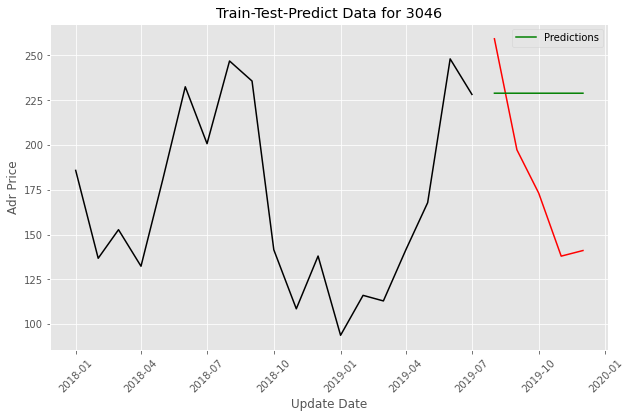

            predicted_mean county_id
2021-03-01      228.947745      1081
2021-04-01      228.947745      1081
2021-05-01      228.947745      1081
2021-06-01      228.947745      1081
2021-07-01      228.947745      1081
2021-08-01      228.947745      1081
2021-09-01      228.947745      1081
2021-10-01      228.947745      1081
2021-11-01      228.947745      1081
2021-12-01      228.947745      1081
2022-01-01      228.947745      1081
2022-02-01      228.947745      1081
2022-03-01      228.947745      1081
2022-04-01      228.947745      1081
2022-05-01      228.947745      1081
2022-06-01      228.947745      1081
2022-07-01      228.947745      1081
Using model 1 for 2643.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.66830D+00    |proj g|=  8.69672D-01

At iterate    5    f=  3.27364D+00    |proj g|=  2.65813D-02

At iterate   10  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  3.67844D+00    |proj g|=  1.19689D-02

At iterate   25    f=  3.67775D+00    |proj g|=  7.48538D-03

At iterate   30    f=  3.67764D+00    |proj g|=  4.15644D-04

At iterate   35    f=  3.67763D+00    |proj g|=  2.94119D-04

At iterate   40    f=  3.67763D+00    |proj g|=  1.70522D-04

At iterate   45    f=  3.67763D+00    |proj g|=  6.63164D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     54      1     0     0   6.632D-05   3.678D+00
  F =   3.6776271033300043     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
            predicted_mean county_id
2021-03-01    

 This problem is unconstrained.
 This problem is unconstrained.


Using model 2 for 3046.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39288D+00    |proj g|=  9.45348D-02

At iterate    5    f=  4.37366D+00    |proj g|=  1.05163D-02

At iterate   10    f=  4.36655D+00    |proj g|=  4.05047D-02

At iterate   15    f=  4.36173D+00    |proj g|=  5.66756D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   5.668D-06   4.362D+00
  F =   4.3617277580158031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_P

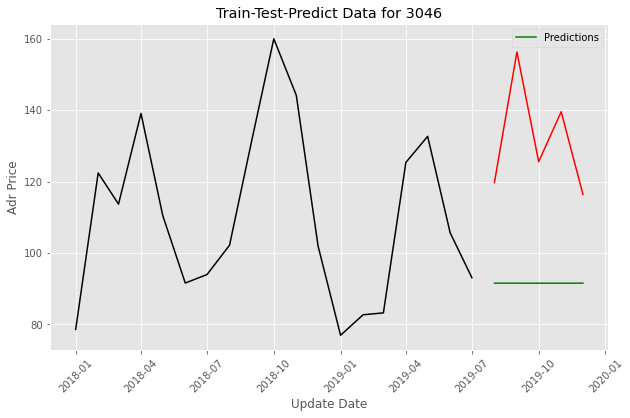

            predicted_mean county_id
2021-03-01       91.567728      3046
2021-04-01       91.567728      3046
2021-05-01       91.567728      3046
2021-06-01       91.567728      3046
2021-07-01       91.567728      3046
2021-08-01       91.567728      3046
2021-09-01       91.567728      3046
2021-10-01       91.567728      3046
2021-11-01       91.567728      3046
2021-12-01       91.567728      3046
2022-01-01       91.567728      3046
2022-02-01       91.567728      3046
2022-03-01       91.567728      3046
2022-04-01       91.567728      3046
2022-05-01       91.567728      3046
2022-06-01       91.567728      3046
2022-07-01       91.567728      3046
Using model 1 for 2696.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30907D+00    |proj g|=  1.19704D+00

At iterate    5    f=  3.57417D+00    |proj g|=  2.47372D-02

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.


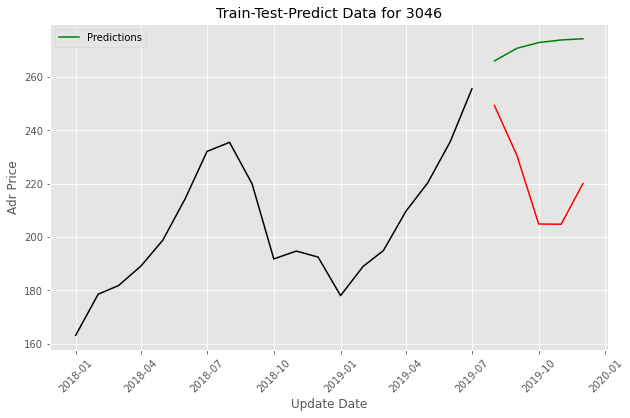

            predicted_mean county_id
2021-03-01      274.741709      2530
2021-04-01      274.741710      2530
2021-05-01      274.741711      2530
2021-06-01      274.741711      2530
2021-07-01      274.741711      2530
2021-08-01      274.741711      2530
2021-09-01      274.741711      2530
2021-10-01      274.741711      2530
2021-11-01      274.741711      2530
2021-12-01      274.741711      2530
2022-01-01      274.741711      2530
2022-02-01      274.741711      2530
2022-03-01      274.741711      2530
2022-04-01      274.741711      2530
2022-05-01      274.741711      2530
2022-06-01      274.741711      2530
2022-07-01      274.741711      2530
Using model 1 for 2120.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.00807D+00    |proj g|=  6.63134D-01

At iterate    5    f=  3.72492D+00    |proj g|=  1.84942D-02

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.22596D+00    |proj g|=  1.48926D-03

At iterate   20    f=  4.22588D+00    |proj g|=  2.04609D-04

At iterate   25    f=  4.22587D+00    |proj g|=  3.00095D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     32      1     0     0   9.131D-06   4.226D+00
  F =   4.2258713145000932     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root mean square error for the3046 is 25.645722261579916
                   adr  Predictions
date                               
2019-08-01  196.337812   182.947422
2019-09-01  183.719912   178.407960
2019-10-01  147.840173   176.501

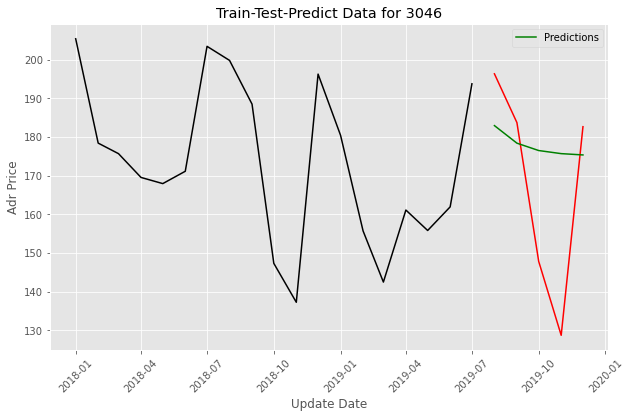

            predicted_mean county_id
2021-03-01      175.121677       808
2021-04-01      175.121677       808
2021-05-01      175.121677       808
2021-06-01      175.121677       808
2021-07-01      175.121677       808
2021-08-01      175.121677       808
2021-09-01      175.121677       808
2021-10-01      175.121677       808
2021-11-01      175.121677       808
2021-12-01      175.121677       808
2022-01-01      175.121677       808
2022-02-01      175.121677       808
2022-03-01      175.121677       808
2022-04-01      175.121677       808
2022-05-01      175.121677       808
2022-06-01      175.121677       808
2022-07-01      175.121677       808
Using model 2 for 2909.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.55724D+00    |proj g|=  7.98079D-02

At iterate    5    f=  3.55250D+00    |proj g|=  1.18293D-02

At iterate   10  

 This problem is unconstrained.


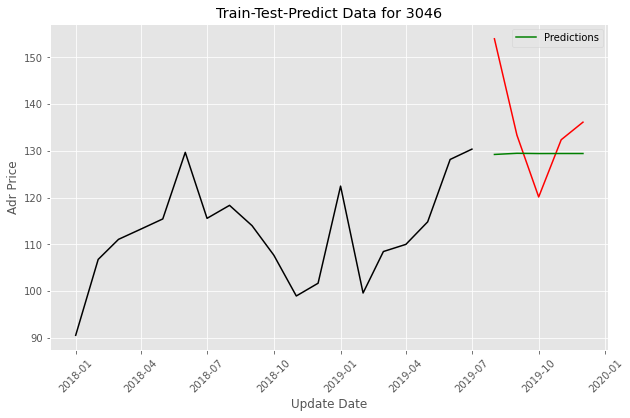

            predicted_mean county_id
2021-03-01      129.435277      2909
2021-04-01      129.435277      2909
2021-05-01      129.435277      2909
2021-06-01      129.435277      2909
2021-07-01      129.435277      2909
2021-08-01      129.435277      2909
2021-09-01      129.435277      2909
2021-10-01      129.435277      2909
2021-11-01      129.435277      2909
2021-12-01      129.435277      2909
2022-01-01      129.435277      2909
2022-02-01      129.435277      2909
2022-03-01      129.435277      2909
2022-04-01      129.435277      2909
2022-05-01      129.435277      2909
2022-06-01      129.435277      2909
2022-07-01      129.435277      2909
Using model 2 for 1660.0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.32803D+00    |proj g|=  1.85556D-01

At iterate    5    f=  4.29988D+00    |proj g|=  8.98499D-02

At iterate   10    f=  4.28041D+00    |proj g|=  1.84448D-02

At iterate   15    f=  4.27559D+00    |proj g|=  5.08091D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   2.292D-06   4.276D+00
  F =   4.2755711730488715     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The root

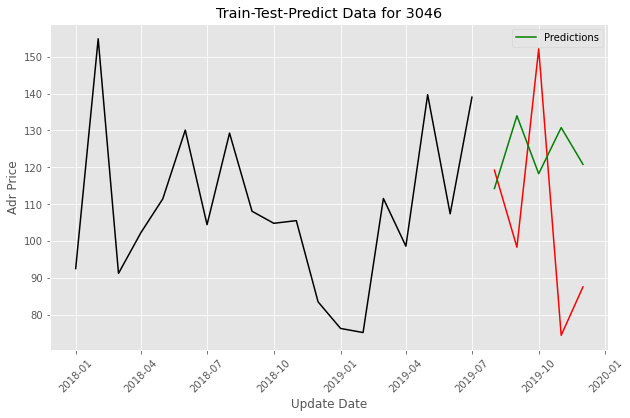

            predicted_mean county_id
2021-03-01      125.383734      1660
2021-04-01      125.122946      1660
2021-05-01      125.330639      1660
2021-06-01      125.165231      1660
2021-07-01      125.296962      1660
2021-08-01      125.192051      1660
2021-09-01      125.275603      1660
2021-10-01      125.209062      1660
2021-11-01      125.262055      1660
2021-12-01      125.219851      1660
2022-01-01      125.253463      1660
2022-02-01      125.226694      1660
2022-03-01      125.248013      1660
2022-04-01      125.231035      1660
2022-05-01      125.244556      1660
2022-06-01      125.233788      1660
2022-07-01      125.242364      1660
Using model 2 for 608.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08332D+01    |proj g|=  6.53319D+00

At iterate    5    f=  6.21379D+00    |proj g|=  1.94965D-01

At iterate   10   

 This problem is unconstrained.


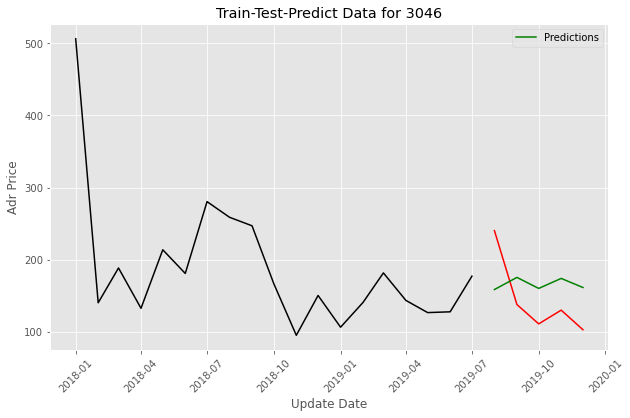

            predicted_mean county_id
2021-03-01      168.797499       608
2021-04-01      166.108054       608
2021-05-01      168.549985       608
2021-06-01      166.332789       608
2021-07-01      168.345934       608
2021-08-01      166.518061       608
2021-09-01      168.177712       608
2021-10-01      166.670801       608
2021-11-01      168.039029       608
2021-12-01      166.796721       608
2022-01-01      167.924697       608
2022-02-01      166.900530       608
2022-03-01      167.830442       608
2022-04-01      166.986111       608
2022-05-01      167.752737       608
2022-06-01      167.056665       608
2022-07-01      167.688677       608
Using model 1 for 95.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33493D+00    |proj g|=  4.01638D-01

At iterate    5    f=  3.07194D+00    |proj g|=  1.48249D-02

At iterate   10    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  4.20501D+00    |proj g|=  3.80620D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     50      1     0     0   2.326D-05   4.205D+00
  F =   4.2050104003950484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
            predicted_mean county_id
2021-03-01      125.484414       926
2021-04-01      125.427302       926
2021-05-01      125.962169       926
2021-06-01      125.986641       926
2021-07-01      126.451166       926
2021-08-01      126.536286       926
2021-09-01      126.948522       926
2021-10-01      127.078725       926
2021-11-01      127.452091  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


In [30]:
# using the same models above but this time along with modelling we are also making predictions and storing them in the data
final_df = pd.Series([])
for county_id in ld_df["county_id"].unique():
    if county_id in model_2_county_id:
        print("Using model 2 for "+ str(county_id))
        
        seas_df_pd_county = seas_df_pd[seas_df_pd["county_id"] == county_id]
        train = seas_df_pd_county[seas_df_pd_county.index < pd.to_datetime("2019-08-01", format='%Y-%m-%d')]
        test = seas_df_pd_county[seas_df_pd_county.index >= pd.to_datetime("2019-08-01", format='%Y-%m-%d')][["adr"]]
        y = train['adr']
        ARMAmodel1 = SARIMAX(y, order = (1, 1, 1))
        ARMAmodel1 = ARMAmodel1.fit()
        y_pred = ARMAmodel1.get_forecast(len(test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.5)
        y_pred_df["Predictions"] = ARMAmodel1.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = test.index
        y_pred_out = y_pred_df["Predictions"] 
        print("The root mean square error for the" + str(county) + " is " + str(math.sqrt(((y_pred_out - test.iloc[:,0]) ** 2).mean())))
        print(pd.concat([test.iloc[:,0], y_pred_out], axis=1))

        rmse_error1.update({county: math.sqrt(((y_pred_out - test.iloc[:,0]) ** 2).mean())})



        plt.plot(train[["adr"]], color = "black")
        plt.plot(test[["adr"]], color = "red")
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.ylabel('Adr Price')
        plt.xlabel('Update Date')
        plt.xticks(rotation=45)
        plt.title("Train-Test-Predict Data for " + str(county))
        plt.legend()
        plt.show()
        
        temp_df = pd.DataFrame(ARMAmodel1.predict(start = ld_df.index[0]- datetime.timedelta(days=30), end = ld_df.index[-1]+ datetime.timedelta(days=210)))
        temp_df["county_id"] = str(int(county_id))
        print(temp_df)
        if not final_df.empty:
            final_df = final_df.append(temp_df, ignore_index=False)
        else:
            final_df = temp_df
    elif county_id in model_3_county_id:
        eas_df_pd_county = seas_df_pd[seas_df_pd["county_id"] == county_id]
        train = seas_df_pd_county[seas_df_pd_county.index < pd.to_datetime("2019-08-01", format='%Y-%m-%d')]
        test = seas_df_pd_county[seas_df_pd_county.index >= pd.to_datetime("2019-08-01", format='%Y-%m-%d')][["adr"]]
        y = train['adr']
        ARMAmodel2 = SARIMAX(y, order = (2, 1, 2))
        ARMAmodel2 = ARMAmodel2.fit()
        y_pred = ARMAmodel2.get_forecast(len(test.index))
        y_pred_df = y_pred.conf_int(alpha = 0.5)
        y_pred_df["Predictions"] = ARMAmodel1.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = test.index
        y_pred_out = y_pred_df["Predictions"] 
        print("The root mean square error for the" + str(county) + " is " + str(math.sqrt(((y_pred_out - test.iloc[:,0]) ** 2).mean())))
        print(pd.concat([test.iloc[:,0], y_pred_out], axis=1))

        rmse_error1.update({county: math.sqrt(((y_pred_out - test.iloc[:,0]) ** 2).mean())})
        plt.plot(train[["adr"]], color = "black")
        plt.plot(test[["adr"]], color = "red")
        plt.plot(y_pred_out, color='green', label = 'Predictions')
        plt.ylabel('Adr Price')
        plt.xlabel('Update Date')
        plt.xticks(rotation=45)
        plt.title("Train-Test-Predict Data for " + str(county))
        plt.legend()
        plt.show()
        
        temp_df = pd.DataFrame(ARMAmodel2.predict(start = ld_df.index[0]- datetime.timedelta(days=30), end = ld_df.index[-1]+ datetime.timedelta(days=210)))
        temp_df["county_id"] = str(int(county_id))
        print(temp_df)
        if not final_df.empty:
            final_df = final_df.append(temp_df, ignore_index=False)
        else:
            final_df = temp_df
        
    else:
        try:
            print("Using model 1 for "+ str(county_id))

            seas_df_pd_county = seas_df_pd[seas_df_pd["county_id"] == county_id]
            train = seas_df_pd_county[seas_df_pd_county.index < pd.to_datetime("2019-07-01", format='%Y-%m-%d')]
            test = seas_df_pd_county[seas_df_pd_county.index >= pd.to_datetime("2019-07-01", format='%Y-%m-%d')][["adr"]]
            y = train['adr']
            ARMAmodel0 = SARIMAX(y, order = (2, 2, 2))
            ARMAmodel0 = ARMAmodel0.fit()


            temp_df = pd.DataFrame(ARMAmodel0.predict(start = ld_df.index[0]- datetime.timedelta(days=30), end = ld_df.index[-1]+ datetime.timedelta(days=210)))
            temp_df["county_id"] = str(int(county_id))
            print(temp_df)
            if not final_df.empty:
                final_df = final_df.append(temp_df, ignore_index=False)
            else:
                final_df = temp_df
        except:
            print("failed for" + str(county_id))
    
    

In [31]:
final_df[final_df["county_id"] == "11"]

predicted_mean county_id
2021-03-01       79.344686        11
2021-04-01       79.575305        11
2021-05-01       79.805955        11
2021-06-01       80.036600        11
2021-07-01       80.267237        11
2021-08-01       80.497882        11
2021-09-01       80.728524        11
2021-10-01       80.959166        11
2021-11-01       81.189809        11
2021-12-01       81.420451        11
2022-01-01       81.651094        11
2022-02-01       81.881736        11
2022-03-01       82.112378        11
2022-04-01       82.343021        11
2022-05-01       82.573663        11
2022-06-01       82.804306        11
2022-07-01       83.034948        11

In [17]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(final_df.groupby("predicted_mean").count().sort_values("county_id"))

                county_id
predicted_mean           
76.957672               1
180.824720              1
177.469667              1
176.134252              1
175.121677              1
175.121677              1
175.121677              1
175.121677              1
175.121677              1
181.353547              1
175.121677              1
175.121677              1
175.121677              1
175.121677              1
175.121677              1
174.798837              1
173.500850              1
173.500850              1
173.500850              1
175.121677              1
181.449330              1
181.466847              1
181.639033              1
188.136205              1
187.707094              1
187.277982              1
186.931791              1
186.848871              1
186.573342              1
186.419760              1
185.990648              1
185.561537              1
185.132426              1
184.703313              1
184.274205              1
183.995905              1
183.845090  

In [32]:
final_df.to_csv("counties_adr_prjection.csv")

22/07/24 04:05:48 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 20623069 ms exceeds timeout 120000 ms
22/07/24 04:05:48 WARN SparkContext: Killing executors is not supported by current scheduler.
